## A) Import libs

In [2]:
#import libs
import numpy as np 
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt 
# import math
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# import ipywidgets as widgets
# from ipywidgets import interact
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import matplotlib.lines as mlines

# import files 
from DataSet import DataSet
from DataGen import DataGen 
from DataGen import DataGen
from DataAugmentation import augment_with_horizontal_flip, augment_with_vertical_flip, augment_with_opposit_map_values
from utilities import standardize_vector, map_plot, labeled_inputs_plot, compare_output_label, plot_combinations
#from MapUpdateNetwork import MapUpdateNetwork

## B) Build NN models

In [3]:
class MapUpdateNetwork_1(nn.Module):
    """
    A convolutional neural network designed for processing and updating map-like structures.
    The network takes four input images as input, encodes their features, and decodes them 
    to generate an output map of the same spatial dimensions as the inputs.

    Attributes:
        encoder (nn.Sequential): Encoder that reduces spatial dimensions and extracts high-level features.
        decoder (nn.Sequential): Decoder that reconstructs the spatial dimensions from encoded features.

    Methods:
        __init__(in_channels, out_channels, out_channels_first_conv):
            Initializes the network with configurable input/output channels and feature depth.
        forward(img1, img2, img3, img4):
            Performs the forward pass by concatenating the input images, encoding their features, 
            and decoding them to produce the final map.
    """

    def __init__(self, in_channels=4, out_channels=2, out_channels_first_conv=16):
        """
        Initializes the MapUpdateNetwork.

        Args:
            in_channels (int): Number of input channels. Defaults to 4 (for concatenated input images).
            out_channels (int): Number of output channels. Defaults to 2.
            out_channels_first_conv (int): Number of channels in the first convolutional layer. Defaults to 16.
        """
        super(MapUpdateNetwork_1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 4 x 8x4 => 16 x 8x4
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1), # 16 x 8x4 => 32 x 4x2
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 32 x 4x2 => 64 x 4x2
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4*out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 64 x 4x2 => 32 x 4x2
            nn.ReLU(),
            nn.ConvTranspose2d(2*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1), # 32 x 4x2 => 16 x 8x4
            nn.ReLU()
        )
        self.final_layer1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) # 16 x 8x4 => 1 x 8x4
        self.final_layer2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), # 16 x 8x4 => 1 x 8x4
            nn.Sigmoid()
        )

        self.train_losses = []
        self.validation_losses = []

    def forward(self, img1, img2, img3, img4):
        """
        Forward pass of the network. Combines four input images, processes them through
        an encoder-decoder architecture, and outputs an updated map.

        Args:
            img1 (torch.Tensor): First input image tensor of shape (B, C, H, W).
            img2 (torch.Tensor): Second input image tensor of shape (B, C, H, W).
            img3 (torch.Tensor): Third input image tensor of shape (B, C, H, W).
            img4 (torch.Tensor): Fourth input image tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Output map tensor of shape (B, out_channels, H, W), where 
                          H and W are the height and width of the input images.
        """
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        channel1 = self.final_layer1(x)  # Output non contraint
        channel2 = 3 * self.final_layer2(x)  # Contraint entre [0, 3]
        return torch.cat((channel1, channel2), dim=1)

In [4]:
class MapUpdateNetwork_2(nn.Module):
    def __init__(self, in_channels=4, out_channels_first_conv=16):
        super(MapUpdateNetwork_2, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 4 x 8x4 => 16 x 8x4
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1), # 16 x 8x4 => 32 x 4x2
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 32 x 4x2 => 64 x 4x2
            nn.ReLU()
        )
        
        # Decoder for 2 outputs 
        self.decoder_shared = nn.ConvTranspose2d(4*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1) # 64 x 4x2 => 16 x 8x2
        self.decoder_output1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) # 16 x 8x4 => 1 x 8x4
        self.decoder_output2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), # 16 x 8x4 => 1 x 8x4
            nn.Sigmoid()  # Normalisation [0, 1]
        )

        self.train_losses = []
        self.validation_losses = []

    def forward(self, img1, img2, img3, img4):
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder_shared(x)
        
        # 2 different outputs 
        output1 = self.decoder_output1(x)  
        output2 = self.decoder_output2(x) * 3  # Rescale pour [0, 3]
        
        return torch.cat((output1, output2), dim=1)


In [5]:
class MapUpdateNetwork_3(nn.Module):
    def __init__(self, in_channels=4, out_channels_first_conv=16):
        super(MapUpdateNetwork_3, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 4 x 8x4 => 16 x 8x4
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1), # 16 x 8x4 => 32 x 4x2
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 32 x 4x2 => 64 x 4x2
            nn.ReLU()
        )
        
        # Decoder for 2 outputs 
        self.decoder_shared = nn.Sequential(
            nn.ConvTranspose2d(4*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1), # 64 x 4x2 => 16 x 8x2
            nn.ReLU()
        )
        self.decoder_output1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) # 16 x 8x4 => 1 x 8x4
        self.decoder_output2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), # 16 x 8x4 => 1 x 8x4
            nn.Sigmoid()  # Normalisation [0, 1]
        )

        self.train_losses = []
        self.validation_losses = []

    def forward(self, img1, img2, img3, img4):
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder_shared(x)
        
        # 2 different outputs 
        output1 = self.decoder_output1(x)  
        output2 = self.decoder_output2(x) * 3  # Rescale pour [0, 3]
        
        return torch.cat((output1, output2), dim=1)

In [6]:
class MapUpdateNetwork_4(nn.Module):
    """
    A fully connected encoder-decoder network designed to process flattened input data.
    The network takes four input images of shape (B, 4, 8, 4), flattens them, 
    and outputs an image of shape (B, 2, 8, 4) after encoding and decoding.

    Attributes:
        encoder (nn.Sequential): Encoder that reduces the dimensionality of input data.
        decoder (nn.Sequential): Decoder that reconstructs the original dimensionality from encoded features.

    Methods:
        __init__(input_dim, latent_dim, output_dim):
            Initializes the network with configurable input, latent, and output dimensions.
        forward(img1, img2, img3, img4):
            Performs the forward pass by concatenating the flattened input images, encoding their features,
            and decoding them to produce the final output image.
    """

    def __init__(self, input_dim=4*8*4, output_dim=(2, 8, 4)):
        """
        Initializes the MapUpdateNetwork_2.

        Args:
            input_dim (int): Dimensionality of the flattened input data (4 * C * H * W).
            output_dim (tuple): Shape of the output image (C, H, W), defaults to (2, 8, 4).
        """
        super(MapUpdateNetwork_4, self).__init__()
        self.output_dim = output_dim
        self.flattened_output_dim = output_dim[1] * output_dim[2]  # 1 * 8 * 4 = 32

        # Encoder: Fully connected layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),  # Flattened input to latent space
            nn.ReLU(),
            nn.Linear(256, 512),  # Additional encoding layer
            nn.ReLU(),
            nn.Linear(512, 1024),  # Additional encoding layer
            nn.ReLU()
        )

        # Decoder: Fully connected layers
        self.decoder = nn.Sequential(
            nn.Linear(1024, 512),  # Latent to intermediate space
            nn.ReLU(),
            nn.Linear(512, 256),  # Latent to intermediate space
            nn.ReLU(),
            nn.Linear(256, 128),  # Latent to intermediate space
            nn.ReLU(),
            nn.Linear(128, 64),  # Decode back to flattened output
            nn.ReLU()
        )

        self.final_layer1 = nn.Linear(64, self.flattened_output_dim)  # Non-constrained output
        self.final_layer2 = nn.Sequential(
            nn.Linear(64, self.flattened_output_dim),  # Constrained output
            nn.Sigmoid()
        )

        self.train_losses = []
        self.validation_losses = []

    def forward(self, img1, img2, img3, img4):
        """
        Forward pass of the network. Combines four input images, processes them through
        an encoder-decoder architecture, and outputs an updated map in the same shape as the inputs.

        Args:
            img1 (torch.Tensor): First input image tensor of shape (B, 4, 8, 4).
            img2 (torch.Tensor): Second input image tensor of shape (B, 4, 8, 4).
            img3 (torch.Tensor): Third input image tensor of shape (B, 4, 8, 4).
            img4 (torch.Tensor): Fourth input image tensor of shape (B, 4, 8, 4).

        Returns:
            torch.Tensor: Output tensor of shape (B, 2, 8, 4), which is the same shape as the input labels.
        """
        # Flatten the input images (B, 4, 8, 4) => (B, 4*8*4)
        x = torch.cat((img1, img2, img3, img4), dim=1)  # Concatenate along the channel dimension
        x = x.view(x.size(0), -1)  # Flatten to (B, 4*8*4)

        # Encoding and decoding
        x = self.encoder(x)
        x = self.decoder(x)

        # Output layer
        channel1 = self.final_layer1(x)  # Non-constrained output (B, flattened_output_dim)
        channel2 = 3 * self.final_layer2(x)  # Constrained output between [0, 3] (B, flattened_output_dim)

        # Combine the two output channels and reshape back to the image format (B, 2, 8, 4)
        output = torch.cat((channel1, channel2), dim=1)
        output = output.view(x.size(0), *self.output_dim)  # Reshape to (B, 2, 8, 4)

        return output


In [7]:
class MapUpdateNetwork_5(nn.Module):
    """
    A convolutional neural network designed for processing and updating map-like structures.
    The network takes four input images as input, encodes their features using separate encoders, 
    and decodes them to generate an output map of the same spatial dimensions as the inputs.

    Attributes:
        encoder1 (nn.Sequential): Encoder for the first input image.
        encoder2 (nn.Sequential): Encoder for the second input image.
        encoder3 (nn.Sequential): Encoder for the third input image.
        encoder4 (nn.Sequential): Encoder for the fourth input image.
        decoder (nn.Sequential): Decoder that reconstructs the spatial dimensions from encoded features.

    Methods:
        __init__(in_channels, out_channels, out_channels_first_conv):
            Initializes the network with configurable input/output channels and feature depth.
        forward(img1, img2, img3, img4):
            Performs the forward pass by encoding each input image separately,
            and decoding them to produce the final map.
    """

    def __init__(self, in_channels=4, out_channels=2, out_channels_first_conv=8):
        """
        Initializes the MapUpdateNetwork.

        Args:
            in_channels (int): Number of input channels. Defaults to 4 (for concatenated input images).
            out_channels (int): Number of output channels. Defaults to 2.
            out_channels_first_conv (int): Number of channels in the first convolutional layer. Defaults to 16.
        """
        super(MapUpdateNetwork_5, self).__init__()

        # Encoder for each input image (img1, img2, img3, img4)
        self.encoder1 = self._build_encoder(1, out_channels_first_conv)
        self.encoder2 = self._build_encoder(1, out_channels_first_conv)
        self.encoder3 = self._build_encoder(1, out_channels_first_conv)
        self.encoder4 = self._build_encoder(1, out_channels_first_conv)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4*4 * out_channels_first_conv, 4 * out_channels_first_conv, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4 * out_channels_first_conv, 2 * out_channels_first_conv, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2 * out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

        # Final layers
        self.final_layer1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1)
        self.final_layer2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

        self.train_losses = []
        self.validation_losses = []

    def _build_encoder(self, in_channels, out_channels_first_conv):
        """ Helper function to build a common encoder architecture. """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels_first_conv, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2 * out_channels_first_conv, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(2 * out_channels_first_conv, 4 * out_channels_first_conv, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )

    def forward(self, img1, img2, img3, img4):
        """
        Forward pass of the network. Processes each input image separately through its encoder,
        concatenates the encoded features, and then decodes them to produce an updated map.

        Args:
            img1 (torch.Tensor): First input image tensor of shape (B, C, H, W).
            img2 (torch.Tensor): Second input image tensor of shape (B, C, H, W).
            img3 (torch.Tensor): Third input image tensor of shape (B, C, H, W).
            img4 (torch.Tensor): Fourth input image tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Output map tensor of shape (B, out_channels, H, W), where 
                          H and W are the height and width of the input images.
        """
        # Process each image through its respective encoder
        enc1 = self.encoder1(img1)
        enc2 = self.encoder2(img2)
        enc3 = self.encoder3(img3)
        enc4 = self.encoder4(img4)

        # Concatenate the outputs from all encoders along the channel dimension
        x = torch.cat((enc1, enc2, enc3, enc4), dim=1)

        # Decoder
        x = self.decoder(x)

        # Final layers
        channel1 = self.final_layer1(x)  # Output without constraint
        channel2 = 3 * self.final_layer2(x)  # Output with constraint between [0, 3]

        return torch.cat((channel1, channel2), dim=1)


In [8]:
class MapUpdateNetwork_6(nn.Module):
    """
    A convolutional neural network designed for processing and updating map-like structures.
    The network takes four input images as input, encodes their features, and decodes them 
    to generate an output map of the same spatial dimensions as the inputs.

    Attributes:
        encoder (nn.Sequential): Encoder that reduces spatial dimensions and extracts high-level features.
        decoder (nn.Sequential): Decoder that reconstructs the spatial dimensions from encoded features.

    Methods:
        __init__(in_channels, out_channels, out_channels_first_conv):
            Initializes the network with configurable input/output channels and feature depth.
        forward(img1, img2, img3, img4):
            Performs the forward pass by concatenating the input images, encoding their features, 
            and decoding them to produce the final map.
    """

    def __init__(self, in_channels=4, out_channels=2, out_channels_first_conv=16):
        """
        Initializes the MapUpdateNetwork.

        Args:
            in_channels (int): Number of input channels. Defaults to 4 (for concatenated input images).
            out_channels (int): Number of output channels. Defaults to 2.
            out_channels_first_conv (int): Number of channels in the first convolutional layer. Defaults to 16.
        """
        super(MapUpdateNetwork_6, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 4 x 8x4 => 16 x 8x4
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 16 x 8x4 => 32 x 8x4
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=2, padding=1), # 32 x 8x4 => 64 x 4x2
            nn.ReLU(),
            nn.Conv2d(4*out_channels_first_conv, 8*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 64 x 4x2 => 128 x 4x2
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 128 x 4x2 => 64 x 4x2
            nn.ReLU(),
            nn.ConvTranspose2d(4*out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1), # 64 x 4x2 => 32 x 8x4
            nn.ReLU(),
            nn.ConvTranspose2d(2*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 32 x 4x2 => 16 x 8x4
            nn.ReLU()
        )
        self.final_layer1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) # 16 x 8x4 => 1 x 8x4
        self.final_layer2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), # 16 x 8x4 => 1 x 8x4
            nn.Sigmoid()
        )

        self.train_losses = []
        self.validation_losses = []

    def forward(self, img1, img2, img3, img4):
        """
        Forward pass of the network. Combines four input images, processes them through
        an encoder-decoder architecture, and outputs an updated map.

        Args:
            img1 (torch.Tensor): First input image tensor of shape (B, C, H, W).
            img2 (torch.Tensor): Second input image tensor of shape (B, C, H, W).
            img3 (torch.Tensor): Third input image tensor of shape (B, C, H, W).
            img4 (torch.Tensor): Fourth input image tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Output map tensor of shape (B, out_channels, H, W), where 
                          H and W are the height and width of the input images.
        """
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        channel1 = self.final_layer1(x)  # Output non contraint
        channel2 = 3 * self.final_layer2(x)  # Contraint entre [0, 3]
        return torch.cat((channel1, channel2), dim=1)

In [9]:
class MapUpdateNetwork_7(nn.Module):
    """
    A convolutional neural network designed for processing and updating map-like structures.
    The network takes four input images as input, encodes their features, and decodes them 
    to generate an output map of the same spatial dimensions as the inputs.

    Attributes:
        encoder (nn.Sequential): Encoder that reduces spatial dimensions and extracts high-level features.
        decoder (nn.Sequential): Decoder that reconstructs the spatial dimensions from encoded features.

    Methods:
        __init__(in_channels, out_channels, out_channels_first_conv):
            Initializes the network with configurable input/output channels and feature depth.
        forward(img1, img2, img3, img4):
            Performs the forward pass by concatenating the input images, encoding their features, 
            and decoding them to produce the final map.
    """

    def __init__(self, in_channels=4, out_channels=2, out_channels_first_conv=16):
        """
        Initializes the MapUpdateNetwork.

        Args:
            in_channels (int): Number of input channels. Defaults to 4 (for concatenated input images).
            out_channels (int): Number of output channels. Defaults to 2.
            out_channels_first_conv (int): Number of channels in the first convolutional layer. Defaults to 16.
        """
        super(MapUpdateNetwork_7, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(4*out_channels_first_conv, 8*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(8*out_channels_first_conv, 16*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16*out_channels_first_conv, 8*out_channels_first_conv, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4*out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU()
        )
        self.final_layer1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) 
        self.final_layer2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), 
            nn.Sigmoid()
        )

        self.train_losses = []
        self.validation_losses = []

    def forward(self, img1, img2, img3, img4):
        """
        Forward pass of the network. Combines four input images, processes them through
        an encoder-decoder architecture, and outputs an updated map.

        Args:
            img1 (torch.Tensor): First input image tensor of shape (B, C, H, W).
            img2 (torch.Tensor): Second input image tensor of shape (B, C, H, W).
            img3 (torch.Tensor): Third input image tensor of shape (B, C, H, W).
            img4 (torch.Tensor): Fourth input image tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Output map tensor of shape (B, out_channels, H, W), where 
                          H and W are the height and width of the input images.
        """
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        channel1 = self.final_layer1(x)  # Output non contraint
        channel2 = 3 * self.final_layer2(x)  # Contraint entre [0, 3]
        return torch.cat((channel1, channel2), dim=1)

In [10]:
class MapUpdateNetwork_8(nn.Module):
    """
    A convolutional neural network designed for processing and updating map-like structures.
    The network takes four input images as input, encodes their features, and decodes them 
    to generate an output map of the same spatial dimensions as the inputs.

    Attributes:
        encoder (nn.Sequential): Encoder that reduces spatial dimensions and extracts high-level features.
        decoder (nn.Sequential): Decoder that reconstructs the spatial dimensions from encoded features.

    Methods:
        __init__(in_channels, out_channels, out_channels_first_conv):
            Initializes the network with configurable input/output channels and feature depth.
        forward(img1, img2, img3, img4):
            Performs the forward pass by concatenating the input images, encoding their features, 
            and decoding them to produce the final map.
    """

    def __init__(self, in_channels=4, out_channels=2, out_channels_first_conv=16):
        """
        Initializes the MapUpdateNetwork.

        Args:
            in_channels (int): Number of input channels. Defaults to 4 (for concatenated input images).
            out_channels (int): Number of output channels. Defaults to 2.
            out_channels_first_conv (int): Number of channels in the first convolutional layer. Defaults to 16.
        """
        super(MapUpdateNetwork_8, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(4*out_channels_first_conv, 8*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(4*out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(2*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU()
        )
        self.final_layer1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) 
        self.final_layer2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), 
            nn.Sigmoid()
        )

        self.train_losses = []
        self.validation_losses = []

    def forward(self, img1, img2, img3, img4):
        """
        Forward pass of the network. Combines four input images, processes them through
        an encoder-decoder architecture, and outputs an updated map.

        Args:
            img1 (torch.Tensor): First input image tensor of shape (B, C, H, W).
            img2 (torch.Tensor): Second input image tensor of shape (B, C, H, W).
            img3 (torch.Tensor): Third input image tensor of shape (B, C, H, W).
            img4 (torch.Tensor): Fourth input image tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Output map tensor of shape (B, out_channels, H, W), where 
                          H and W are the height and width of the input images.
        """
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        channel1 = self.final_layer1(x)  # Output non contraint
        channel2 = 3 * self.final_layer2(x)  # Contraint entre [0, 3]
        return torch.cat((channel1, channel2), dim=1)

In [11]:
class MapUpdateNetwork_9(nn.Module):
    """
    A convolutional neural network designed for processing and updating map-like structures.
    The network takes four input images as input, encodes their features, and decodes them 
    to generate an output map of the same spatial dimensions as the inputs.

    Attributes:
        encoder (nn.Sequential): Encoder that reduces spatial dimensions and extracts high-level features.
        decoder (nn.Sequential): Decoder that reconstructs the spatial dimensions from encoded features.

    Methods:
        __init__(in_channels, out_channels, out_channels_first_conv):
            Initializes the network with configurable input/output channels and feature depth.
        forward(img1, img2, img3, img4):
            Performs the forward pass by concatenating the input images, encoding their features, 
            and decoding them to produce the final map.
    """

    def __init__(self, in_channels=4, out_channels=2, out_channels_first_conv=16):
        """
        Initializes the MapUpdateNetwork.

        Args:
            in_channels (int): Number of input channels. Defaults to 4 (for concatenated input images).
            out_channels (int): Number of output channels. Defaults to 2.
            out_channels_first_conv (int): Number of channels in the first convolutional layer. Defaults to 16.
        """
        super(MapUpdateNetwork_9, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(4*out_channels_first_conv, 8*out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(8*out_channels_first_conv, 16*out_channels_first_conv, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16*out_channels_first_conv, 8*out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(4*out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=1, padding=1), 
            nn.ReLU()
        )
        self.final_layer1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) 
        self.final_layer2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), 
            nn.Sigmoid()
        )

        self.train_losses = []
        self.validation_losses = []

    def forward(self, img1, img2, img3, img4):
        """
        Forward pass of the network. Combines four input images, processes them through
        an encoder-decoder architecture, and outputs an updated map.

        Args:
            img1 (torch.Tensor): First input image tensor of shape (B, C, H, W).
            img2 (torch.Tensor): Second input image tensor of shape (B, C, H, W).
            img3 (torch.Tensor): Third input image tensor of shape (B, C, H, W).
            img4 (torch.Tensor): Fourth input image tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Output map tensor of shape (B, out_channels, H, W), where 
                          H and W are the height and width of the input images.
        """
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        channel1 = self.final_layer1(x)  # Output non contraint
        channel2 = 3 * self.final_layer2(x)  # Contraint entre [0, 3]
        return torch.cat((channel1, channel2), dim=1)

## C) Training and evaluation functions

In [12]:
# Define training function
def train_model(model, train_loader, validation_loader, criterion_function, optimizer, scheduler, num_epochs=20, device="cpu"):
    """
    Trains the given model using the provided data loaders.

    Args:
        model (nn.Module): The neural network to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        validation_loader (DataLoader): DataLoader for the validation dataset.
        criterion_function : Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        scheduler (torch.optim.lr_scheduler.???): Scheduler to adjust learning rate.
        num_epochs (int): Number of epochs to train. Default is 20.
        device (str): Device to use ('cpu' or 'cuda'). Default is 'cpu'.

    Returns:
        model (nn.Module): Trained model.
    """

    model.to(device)
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(*torch.split(inputs, 1, dim=1))  # Split into 4 inputs
            loss = criterion_function(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(*torch.split(inputs, 1, dim=1))
                loss = criterion_function(outputs, targets)
                validation_loss += loss.item()

        # Adjust learning rate using scheduler
        scheduler.step(validation_loss / len(validation_loader))

        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {train_loss / len(train_loader):.10f}, "
              f"Validation Loss: {validation_loss / len(validation_loader):.10f}, "
              f"learning rate: {scheduler.get_last_lr()[0]}")
        
        model.train_losses.append(train_loss / len(train_loader))
        model.validation_losses.append(validation_loss / len(validation_loader))

    return model


In [13]:
# Define evaluation function
def evaluate_model(model, test_loader, criterion_function, device="cpu"):
    """
    Evaluates the trained model on a test dataset.

    Args:
        model (nn.Module): Trained neural network.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion_function : Loss function.
        device (str): Device to use ('cpu' or 'cuda'). Default is 'cpu'.

    Returns:
        float: Average loss on the test set.
    """
    model.eval()
    model.to(device)
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(*torch.split(inputs, 1, dim=1))
            loss = criterion_function(outputs, targets)
            test_loss += loss.item()
    return test_loss / len(test_loader)

## D) Load data from pth file

In [14]:
def concatenate_dataset(input_files):
    """
    Concatène les données de plusieurs fichiers.

    Args:
        input_files (list of str): Liste des chemins des fichiers à charger.
    """
    # Initialisation des listes pour stocker les données concaténées
    all_train_input = []
    all_train_label = []
    all_descriptions = []

    # Charger et concaténer les données
    for file in input_files:
        loaded_data = torch.load(file, weights_only=True)
        all_train_input.append(loaded_data["train_input"])
        all_train_label.append(loaded_data["train_label"])
        all_descriptions.append(loaded_data["description"])

    # Concaténer les tenseurs et les listes
    concatenated_train_input = torch.cat(all_train_input, dim=0)
    concatenated_train_label = torch.cat(all_train_label, dim=0)
    concatenated_description = "; ".join(all_descriptions)

    # Sauvegarder les données concaténées
    output_data = {
        "train_input": concatenated_train_input,
        "train_label": concatenated_train_label,
        "description": concatenated_description,
    }
    return(output_data)

### D.1) For rats 

In [26]:
nb_queries = '2to20'
nb_k_comb = 'multi'
LETTER = 'C2'

In [27]:
input_files = [f'dataset/emgALLrat/og_{LETTER}_{nb_queries}que_{nb_k_comb}kcomb_rat1_emgALL.pth',
               f'dataset/emgALLrat/og_{LETTER}_{nb_queries}que_{nb_k_comb}kcomb_rat2_emgALL.pth',
               f'dataset/emgALLrat/og_{LETTER}_{nb_queries}que_{nb_k_comb}kcomb_rat3_emgALL.pth',
               f'dataset/emgALLrat/og_{LETTER}_{nb_queries}que_{nb_k_comb}kcomb_rat4_emgALL.pth',
              ]

# Load the saved data from a .pth file using PyTorch
loaded_data_1 = concatenate_dataset(input_files)
# The 'weights_only=True' argument ensures that only the model weights (not the entire model) are loaded

# Access the tensors and the description from the loaded data
train_input = loaded_data_1["train_input"]  # The input data for training
train_label = loaded_data_1["train_label"]  # The corresponding labels for the training data
loaded_description = loaded_data_1["description"]  # The description or metadata associated with the data

print(loaded_description)

These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: 2to20que_rat1_emg1
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 nb_comb: [124, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]; These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: 2to20que_rat1_emg2
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 nb_comb: [124, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 

In [28]:
input_files = [f'dataset/emgALLrat/og_{LETTER}_{nb_queries}que_{nb_k_comb}kcomb_rat5_emgALL.pth',
              ]

# Load the saved data from a .pth file using PyTorch
loaded_data_2 = concatenate_dataset(input_files)
# The 'weights_only=True' argument ensures that only the model weights (not the entire model) are loaded

# Access the tensors and the description from the loaded data
test_input = loaded_data_2["train_input"]  # The input data for training
test_label = loaded_data_2["train_label"]  # The corresponding labels for the training data
loaded_description = loaded_data_2["description"]  # The description or metadata associated with the data

print(loaded_description)

These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: 2to20que_rat5_emg1
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 nb_comb: [124, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]; These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: 2to20que_rat5_emg2
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 nb_comb: [124, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 

In [29]:
input_files = [f'dataset/emgALLrat/og_{LETTER}_{nb_queries}que_{nb_k_comb}kcomb_rat6_emgALL.pth',
              ]

# Load the saved data from a .pth file using PyTorch
loaded_data_3 = concatenate_dataset(input_files) 
# The 'weights_only=True' argument ensures that only the model weights (not the entire model) are loaded

# Access the tensors and the description from the loaded data
validation_input = loaded_data_3["train_input"]  # The input data for training
validation_label = loaded_data_3["train_label"]  # The corresponding labels for the training data
loaded_description = loaded_data_3["description"]  # The description or metadata associated with the data

print(loaded_description)

These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: 2to20que_rat6_emg1
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 nb_comb: [124, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]; These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: 2to20que_rat6_emg2
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 nb_comb: [124, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 

### D.2) For NHPs

In [15]:
nb_queries = '2to50'
nb_k_comb = 'multi'
LETTER = 'C4'

In [16]:
input_files = [
    f'dataset/emgCUSTOMnhp/og_{LETTER}_{nb_queries}que_{nb_k_comb}kcomb_ceb1emg1346_ceb2emg134678_mac2emg13_training.pth',
]


# Load the saved data from a .pth file using PyTorch
loaded_data_1 = concatenate_dataset(input_files)
# The 'weights_only=True' argument ensures that only the model weights (not the entire model) are loaded

# Access the tensors and the description from the loaded data
train_input = loaded_data_1["train_input"]  # The input data for training
train_label = loaded_data_1["train_label"]  # The corresponding labels for the training data
loaded_description = loaded_data_1["description"]  # The description or metadata associated with the data

print(loaded_description)

These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: 2to50que_ceb1_emg1
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
 nb_comb: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
 kernel_type: Matern52
 noise_std: 0.05
 output_std: 1
 lengthscale: [0.3, 0.3]; These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose 

In [17]:
input_files = [
    f'dataset/emgCUSTOMnhp/og_{LETTER}_{nb_queries}que_{nb_k_comb}kcomb_ceb1emg5_ceb2emg5_mac2_emg4_test.pth',
]


# Load the saved data from a .pth file using PyTorch
loaded_data_2 = concatenate_dataset(input_files)
# The 'weights_only=True' argument ensures that only the model weights (not the entire model) are loaded

# Access the tensors and the description from the loaded data
test_input = loaded_data_2["train_input"]  # The input data for training
test_label = loaded_data_2["train_label"]  # The corresponding labels for the training data
loaded_description = loaded_data_2["description"]  # The description or metadata associated with the data

print(loaded_description)

These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: 2to50que_ceb1_emg5
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
 nb_comb: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
 kernel_type: Matern52
 noise_std: 0.05
 output_std: 1
 lengthscale: [0.3, 0.3]; These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose 

In [18]:
input_files = [
    f'dataset/emgCUSTOMnhp/og_{LETTER}_{nb_queries}que_{nb_k_comb}kcomb_ceb1emg2_ceb2emg2_mac2emg2_validation.pth',
]


# Load the saved data from a .pth file using PyTorch
loaded_data_3 = concatenate_dataset(input_files) 
# The 'weights_only=True' argument ensures that only the model weights (not the entire model) are loaded

# Access the tensors and the description from the loaded data
validation_input = loaded_data_3["train_input"]  # The input data for training
validation_label = loaded_data_3["train_label"]  # The corresponding labels for the training data
loaded_description = loaded_data_3["description"]  # The description or metadata associated with the data

print(loaded_description)

These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose the queries. And all the samples are NOT uniques 
and these parameters:
 name: 2to50que_ceb1_emg2
 nb_queries: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
 nb_comb: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
 kernel_type: Matern52
 noise_std: 0.05
 output_std: 1
 lengthscale: [0.3, 0.3]; These labeled inputs have the original form.
These pre-labeled inputs were made with the following method : we have used sampling with replacement to choose 

### Visualize the labeled data 

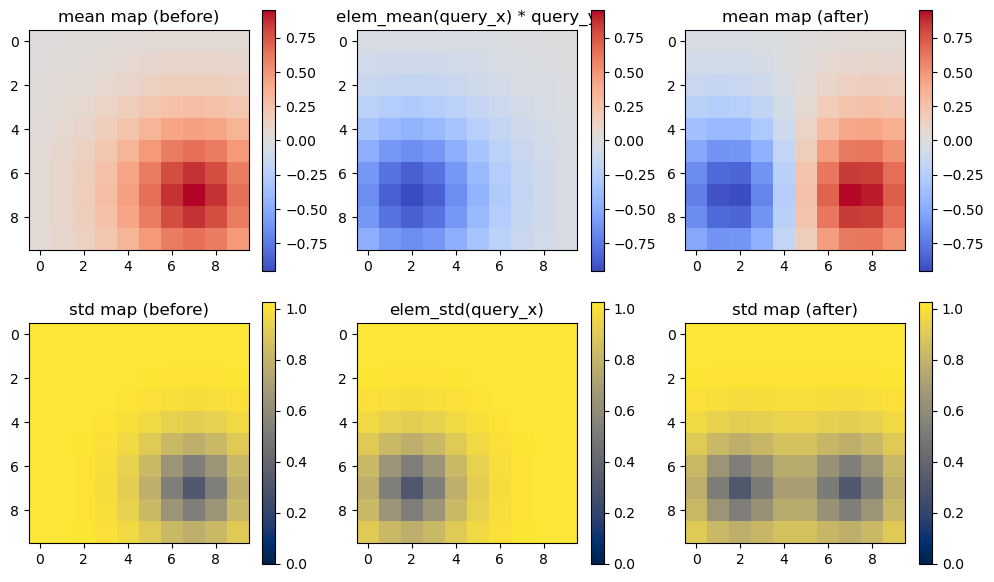

In [19]:
labeled_inputs_plot(train_input=train_input, train_label=train_label, comb_idx=0, values=False, figsize=(10,6))

## E) Training settings

In [34]:
train_X = train_input
train_Y = train_label

validation_X = validation_input
validation_Y = validation_label

test_X = test_input
test_Y = test_label

### Augment training data

In [35]:
print(train_X.shape)
indices = torch.randperm(train_X.size(0))[:10240]
train_X = train_X[indices]
train_Y = train_Y[indices]
print(train_X.shape)

print(validation_X.shape)
indices = torch.randperm(validation_X.size(0))[:1024]
validation_X = validation_X[indices]
validation_Y = validation_Y[indices]
print(validation_X.shape)

print(test_X.shape)
indices = torch.randperm(test_X.size(0))[:1024]
test_X = test_X[indices]
test_Y = test_Y[indices]
print(test_X.shape)

torch.Size([588000, 4, 10, 10])
torch.Size([10240, 4, 10, 10])
torch.Size([147000, 4, 10, 10])
torch.Size([1024, 4, 10, 10])
torch.Size([147000, 4, 10, 10])
torch.Size([1024, 4, 10, 10])


In [36]:
train_X, train_Y = augment_with_horizontal_flip(train_X, train_Y)
train_X, train_Y = augment_with_vertical_flip(train_X, train_Y)
train_X, train_Y = augment_with_opposit_map_values(train_X, train_Y)

In [37]:
print(train_X.shape)
print(validation_X.shape)
print(test_X.shape)

torch.Size([81920, 4, 10, 10])
torch.Size([1024, 4, 10, 10])
torch.Size([1024, 4, 10, 10])


### Dataset size 

In [35]:
# ind_train = random.sample(range(len(train_X)), 2560000)
# train_X = train_X[ind_train]
# train_Y = train_Y[ind_train]

# ind_validation = random.sample(range(len(validation_X)), 128000)
# validation_X = validation_X[ind_validation]
# validation_Y = validation_Y[ind_validation]

# ind_test = random.sample(range(len(test_X)), 64000)
# test_X = test_X[ind_test]
# test_Y = test_Y[ind_test]

### Batchsize and metrics

In [38]:
# Assuming train_X, train_Y, validation_X, validation_Y, test_X, test_Y are provided
batch_size = 256  # Batch size for DataLoader

# Create datasets and data loaders
train_dataset = TensorDataset(train_X, train_Y)
validation_dataset = TensorDataset(validation_X, validation_Y)
test_dataset = TensorDataset(test_X, test_Y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
criterion1 = nn.MSELoss()
criterion2 = nn.MSELoss()  # Si les valeurs dans [0, 3] représentent des classes discrètes

def custom_loss(output, targets):
    target1 = targets[:, 0]  # Extraire les cibles pour le premier canal
    target2 = targets[:, 1]  # Extraire les cibles pour le deuxième canal
    loss1 = criterion1(output[:, 0], target1)
    loss2 = criterion2(output[:, 1], target2) 
    return loss1 + loss2

## F) Training 

In [ ]:
# Initialize model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model_6 = MapUpdateNetwork_6()
optimizer = optim.Adam(model_6.parameters(), lr=1e-3)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold=0.01, 
                              threshold_mode='rel', patience=3, cooldown=2, min_lr=1.e-8)

In [ ]:
# Train the model
num_epochs = 150
trained_model_6 = train_model(model_6, train_loader, validation_loader, 
                              custom_loss, optimizer, scheduler, num_epochs, device)


# Evaluate the model on the test set
test_loss_6 = evaluate_model(trained_model_6, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss_6:.8f}")


name_model = 'model6_C4_2to20que_150epochs_2560kaugtraindata_batchsize256_minlr8'
# Sauvegarde
torch.save({
    'model_state_dict': trained_model_6.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train losses': trained_model_6.train_losses,
    'validation losses': trained_model_6.validation_losses,
    'hyperparameters': (
        'nb_epochs = 150, '
        'LR = 1e-3, '
        'ReduceLRonPlateau factor=0.5 & patience=3, '
        'batch_size=256, '
        'data_type=C4, '
        'nb_queries=2to20, '
        'min_lr=1.e-8'
    )
}, f"model/{name_model}.pth")

In [ ]:
# Initialize model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model_7 = MapUpdateNetwork_7()
optimizer = optim.Adam(model_7.parameters(), lr=1e-3)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold=0.01, 
                              threshold_mode='rel', patience=3, cooldown=2, min_lr=1.e-8)

In [ ]:
# Train the model
num_epochs = 150
trained_model_7 = train_model(model_7, train_loader, validation_loader, 
                              custom_loss, optimizer, scheduler, num_epochs, device)


# Evaluate the model on the test set
test_loss_7 = evaluate_model(trained_model_7, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss_7:.8f}")


name_model = 'model7_C4_2to20que_150epochs_2560kaugtraindata_batchsize256_minlr8'
# Sauvegarde
torch.save({
    'model_state_dict': trained_model_7.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train losses': trained_model_7.train_losses,
    'validation losses': trained_model_7.validation_losses,
    'hyperparameters': (
        'nb_epochs = 150, '
        'LR = 1e-3, '
        'ReduceLRonPlateau factor=0.5 & patience=3, '
        'batch_size=256, '
        'data_type=C4, '
        'nb_queries=2to20, '
        'min_lr=1.e-8'
    )
}, f"model/{name_model}.pth")

In [50]:
# Initialize model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model_8 = MapUpdateNetwork_8()
optimizer = optim.Adam(model_8.parameters(), lr=1e-3)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold=0.01, 
                              threshold_mode='rel', patience=3, cooldown=2, min_lr=1.e-8)

cpu


In [51]:
# Train the model
num_epochs = 5
trained_model_8 = train_model(model_8, train_loader, validation_loader, 
                              custom_loss, optimizer, scheduler, num_epochs, device)


# Evaluate the model on the test set
test_loss_8 = evaluate_model(trained_model_8, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss_8:.8f}")


name_model = 'model8_C4_2to20que_150epochs_2560kaugtraindata_batchsize256_minlr8'
# Sauvegarde
torch.save({
    'model_state_dict': trained_model_8.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train losses': trained_model_8.train_losses,
    'validation losses': trained_model_8.validation_losses,
    'hyperparameters': (
        'nb_epochs = 150, '
        'LR = 1e-3, '
        'ReduceLRonPlateau factor=0.5 & patience=3, '
        'batch_size=256, '
        'data_type=C4, '
        'nb_queries=2to20, '
        'min_lr=1.e-8'
    )
}, f"model/{name_model}.pth")

Epoch [1/5] - Train Loss: 0.2159939094, Validation Loss: 0.0337045360, learning rate: 0.001
Epoch [2/5] - Train Loss: 0.0264922591, Validation Loss: 0.0206456175, learning rate: 0.001
Epoch [3/5] - Train Loss: 0.0185484946, Validation Loss: 0.0198205565, learning rate: 0.001
Epoch [4/5] - Train Loss: 0.0146167867, Validation Loss: 0.0127385452, learning rate: 0.001
Epoch [5/5] - Train Loss: 0.0123162346, Validation Loss: 0.0139187169, learning rate: 0.001
Test Loss: 0.01328993


In [ ]:
# Initialize model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model_9 = MapUpdateNetwork_9()
optimizer = optim.Adam(model_9.parameters(), lr=1e-3)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold=0.01, 
                              threshold_mode='rel', patience=3, cooldown=2, min_lr=1.e-8)

In [ ]:
# Train the model
num_epochs = 150
trained_model_9 = train_model(model_9, train_loader, validation_loader, custom_loss, optimizer, scheduler, num_epochs, device)


# Evaluate the model on the test set
test_loss_9 = evaluate_model(trained_model_9, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss_9:.8f}")


name_model = 'model9_C4_2to20que_150epochs_2560kaugtraindata_batchsize256_minlr8'
# Sauvegarde
torch.save({
    'model_state_dict': trained_model_9.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train losses': trained_model_9.train_losses,
    'validation losses': trained_model_9.validation_losses,
    'hyperparameters': (
        'nb_epochs = 150, '
        'LR = 1e-3, '
        'ReduceLRonPlateau factor=0.5 & patience=3, '
        'batch_size=256, '
        'data_type=C4, '
        'nb_queries=2to20, '
        'min_lr=1.e-8'
    )
}, f"model/{name_model}.pth")

## G) Load model

In [15]:
def load_my_model(model_path, model_t, optimizer_t=None, scheduler_t=None, evaluate=False, plot=False):

    # Load model file
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device == "cpu":
        checkpoint = torch.load(model_path, weights_only=True, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(model_path, weights_only=True)

    # model weights 
    model_t.load_state_dict(checkpoint['model_state_dict'])

    if optimizer_t is not None:
        # optimizer state 
        optimizer_t.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler_t is not None:
        # scheduler state 
        scheduler_t.load_state_dict(checkpoint['scheduler_state_dict'])

    # losses
    train_losses_t = checkpoint['train losses']
    validation_losses_t = checkpoint['validation losses']
    
    if plot:
        plt.plot(np.arange(len(train_losses_t))+1, train_losses_t, label='train losses')
        plt.plot(np.arange(len(validation_losses_t))+1, validation_losses_t, label='validation losses')
        plt.legend()
        plt.xlabel('Number of epochs')
        plt.ylabel('MSE loss (log scale)')
        plt.yscale('log')
        plt.title("Evolution of losses during training")
        plt.show()

    if evaluate:
        # Evaluate the model on the test set
        test_loss = evaluate_model(model_t, test_loader, custom_loss, device)
        print(f"Test Loss: {test_loss:.8f}")

    if (optimizer_t is None) and (scheduler_t is None):
        return model_t, train_losses_t, validation_losses_t
    elif (optimizer_t is not None) and (scheduler_t is None):
        return model_t, optimizer_t, train_losses_t, validation_losses_t
    elif (optimizer_t is None) and (scheduler_t is not None):
        return model_t, scheduler_t, train_losses_t, validation_losses_t
    else: 
        return model_t, optimizer_t, scheduler_t, train_losses_t, validation_losses_t

### First models

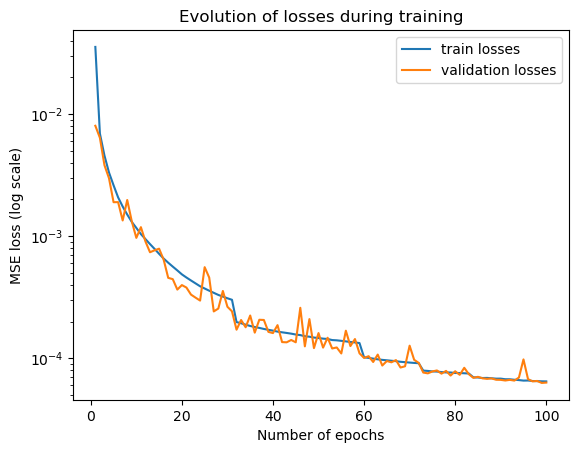

Test Loss: 0.002830


In [62]:
# load model file 
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    checkpoint3 = torch.load("model/model3_100epochs_1280kaugtraindata_batchsize128.pth", weights_only=True, map_location=torch.device('cpu'))
else:
    checkpoint3 = torch.load("model/model3_100epochs_1280kaugtraindata_batchsize128.pth", weights_only=True)

model_t3 = MapUpdateNetwork_3()
optimizer_t3 = optim.Adam(model_t3.parameters(), lr=1e-3)

# model weights
model_t3.load_state_dict(checkpoint3['model_state_dict'])

# optimizer state 
optimizer_t3.load_state_dict(checkpoint3['optimizer_state_dict'])

# losses
train_losses_t3 = checkpoint3['train losses']
validation_losses_t3 = checkpoint3['validation losses']

plt.plot(np.arange(len(train_losses_t3))+1, train_losses_t3, label='train losses')
plt.plot(np.arange(len(validation_losses_t3))+1, validation_losses_t3, label='validation losses')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.show()

# Evaluate the model on the test set
test_loss3 = evaluate_model(model_t3, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss3:.6f}")

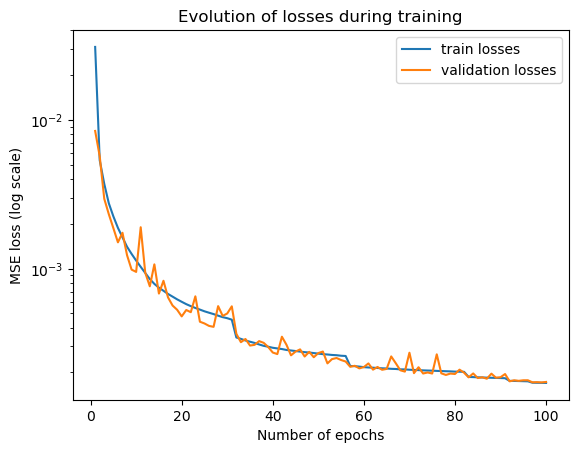

Test Loss: 0.001266


In [63]:
# load model state 
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    checkpoint2 = torch.load("model/model2_100epochs_1280kaugtraindata_batchsize128.pth", weights_only=True, map_location=torch.device('cpu'))
else:
    checkpoint2 = torch.load("model/model2_100epochs_1280kaugtraindata_batchsize128.pth", weights_only=True)

model_t2 = MapUpdateNetwork_2()
optimizer_t2 = optim.Adam(model_t2.parameters(), lr=1e-3)

# model weights 
model_t2.load_state_dict(checkpoint2['model_state_dict'])

# opti state 
optimizer_t2.load_state_dict(checkpoint2['optimizer_state_dict'])

# losses
train_losses_t2 = checkpoint2['train losses']
validation_losses_t2 = checkpoint2['validation losses']

plt.plot(np.arange(len(train_losses_t2))+1, train_losses_t2, label='train losses')
plt.plot(np.arange(len(validation_losses_t2))+1, validation_losses_t2, label='validation losses')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.show()

# Evaluate the model on the test set
test_loss2 = evaluate_model(model_t2, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss2:.6f}")

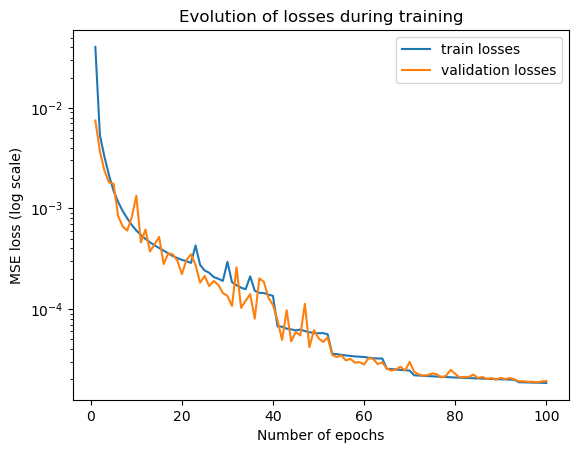

Test Loss: 0.003169


In [64]:
# load model file 
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    checkpoint1 = torch.load("model/model1_100epochs_1280kaugtraindata_batchsize128.pth", weights_only=True, map_location=torch.device('cpu'))
else:
    checkpoint1 = torch.load("model/model1_100epochs_1280kaugtraindata_batchsize128.pth", weights_only=True)

model_t1 = MapUpdateNetwork_1()
optimizer_t1 = optim.Adam(model_t1.parameters(), lr=1e-3)

# model state 
model_t1.load_state_dict(checkpoint1['model_state_dict'])

# optimizer state 
optimizer_t1.load_state_dict(checkpoint1['optimizer_state_dict'])

# losses
train_losses_t1 = checkpoint1['train losses']
validation_losses_t1 = checkpoint1['validation losses']

plt.plot(np.arange(len(train_losses_t1))+1, train_losses_t1, label='train losses')
plt.plot(np.arange(len(validation_losses_t1))+1, validation_losses_t1, label='validation losses')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.show()

# Evaluate the model on the test set
test_loss1 = evaluate_model(model_t1, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss1:.6f}")

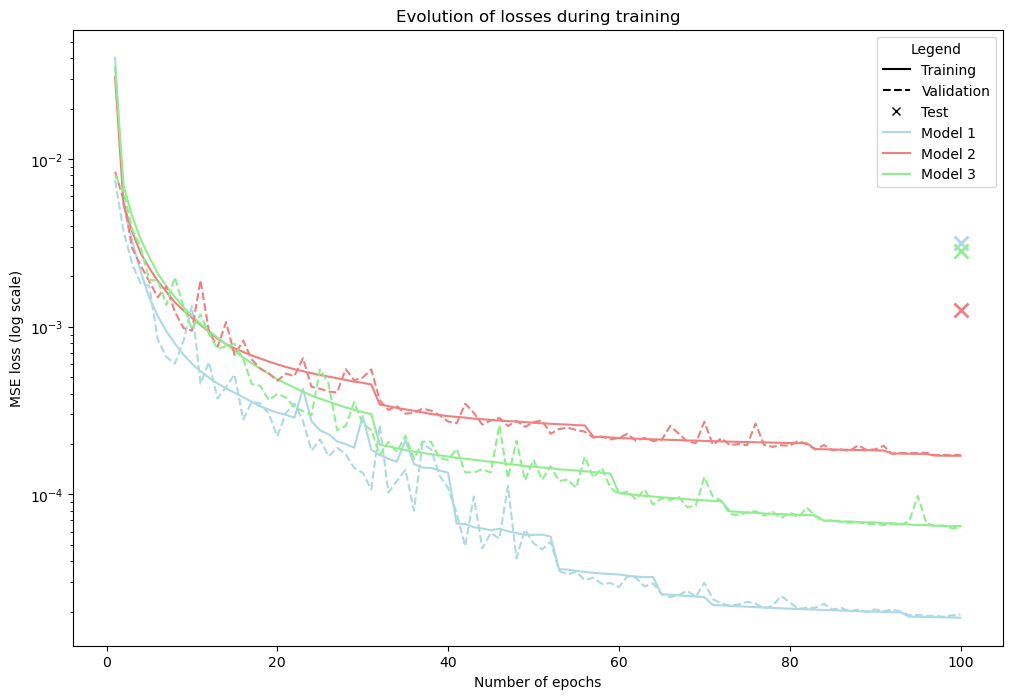

In [65]:
# Assign colors for each model
colors = {
    'model1': 'lightblue',
    'model2': 'lightcoral',
    'model3': 'lightgreen',
}

plt.figure(figsize=(12, 8)) 

# Plot training losses 
plt.plot(np.arange(len(train_losses_t1)) + 1, train_losses_t1, color=colors['model1'], linestyle='-')
plt.plot(np.arange(len(train_losses_t2)) + 1, train_losses_t2, color=colors['model2'], linestyle='-')
plt.plot(np.arange(len(train_losses_t3)) + 1, train_losses_t3, color=colors['model3'], linestyle='-')

# Plot validation losses 
plt.plot(np.arange(len(validation_losses_t1)) + 1, validation_losses_t1, color=colors['model1'], linestyle='--')
plt.plot(np.arange(len(validation_losses_t2)) + 1, validation_losses_t2, color=colors['model2'], linestyle='--')
plt.plot(np.arange(len(validation_losses_t3)) + 1, validation_losses_t3, color=colors['model3'], linestyle='--')

# Plot test losses (x symbol)
plt.plot(100, test_loss1, 'x', color=colors['model1'], markersize=10, markeredgewidth=2)
plt.plot(100, test_loss2, 'x', color=colors['model2'], markersize=10, markeredgewidth=2)
plt.plot(100, test_loss3, 'x', color=colors['model3'], markersize=10, markeredgewidth=2)

# Create custom legend entries
train_line = mlines.Line2D([], [], color='black', linestyle='-', label='Training')
validation_line = mlines.Line2D([], [], color='black', linestyle='--', label='Validation')
test_marker = mlines.Line2D([], [], color='black', marker='x', linestyle='', label='Test')

model1_patch = mlines.Line2D([], [], color=colors['model1'], label='Model 1', linestyle='-')
model2_patch = mlines.Line2D([], [], color=colors['model2'], label='Model 2', linestyle='-')
model3_patch = mlines.Line2D([], [], color=colors['model3'], label='Model 3', linestyle='-')

# Add the legend
plt.legend(handles=[train_line, validation_line, test_marker, model1_patch, model2_patch, model3_patch],
           loc='upper right', title='Legend')

# Add labels and title
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")

# Display the plot
plt.show()


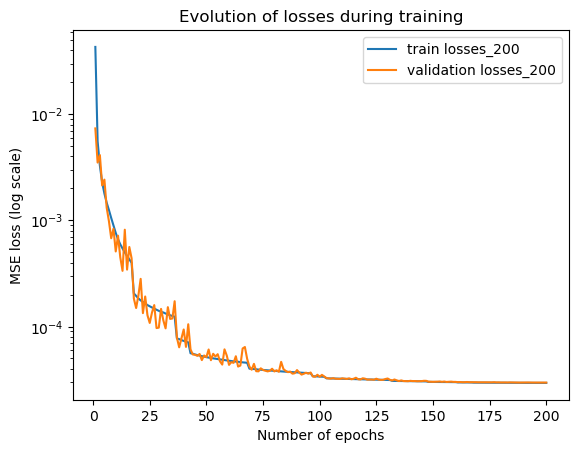

Test Loss: 0.001952


In [66]:
# load model file 
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    checkpoint1_200 = torch.load("model/model1_200epochs_1280kaugtraindata_batchsize128.pth", weights_only=True, map_location=torch.device('cpu'))
else:
    checkpoint1_200 = torch.load("model/model1_200epochs_1280kaugtraindata_batchsize128.pth", weights_only=True)

model_t1_200 = MapUpdateNetwork_1()
optimizer_t1_200 = optim.Adam(model_t1_200.parameters(), lr=1e-3)

# model weigths 
model_t1_200.load_state_dict(checkpoint1_200['model_state_dict'])

# optimizer state 
optimizer_t1_200.load_state_dict(checkpoint1_200['optimizer_state_dict'])

# losses
train_losses_t1_200 = checkpoint1_200['train losses']
validation_losses_t1_200 = checkpoint1_200['validation losses']

plt.plot(np.arange(len(train_losses_t1_200))+1, train_losses_t1_200, label='train losses_200')
plt.plot(np.arange(len(validation_losses_t1_200))+1, validation_losses_t1_200, label='validation losses_200')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.show()

# Evaluate the model on the test set
test_loss1_200 = evaluate_model(model_t1_200, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss1_200:.6f}")

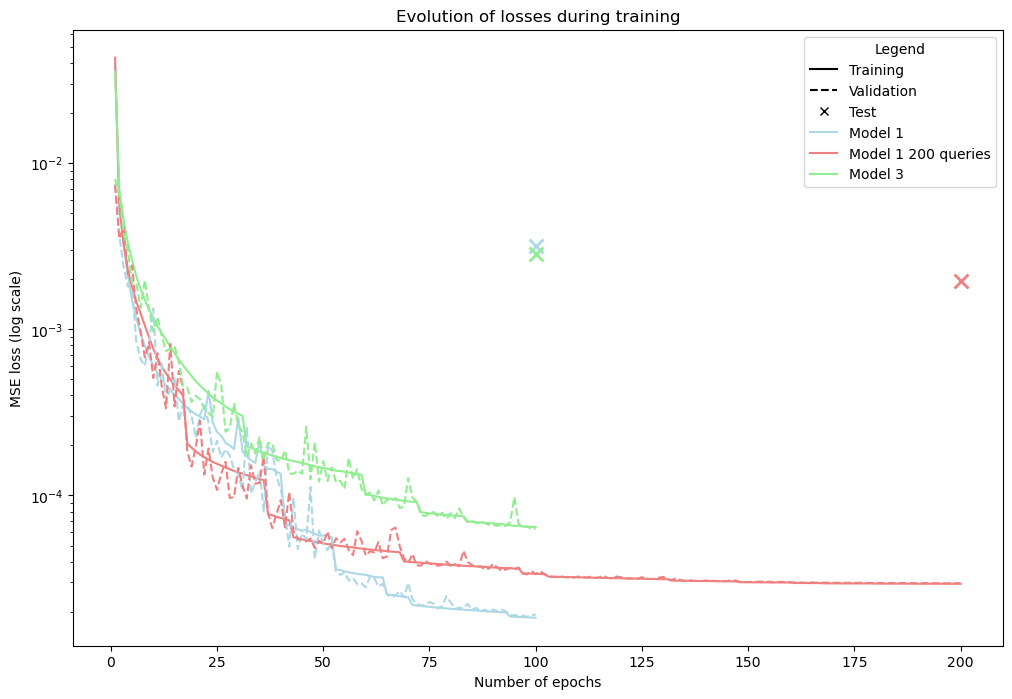

In [67]:
# Assign colors for each model
colors = {
    'model1': 'lightblue',
    'model1 200 queries': 'lightcoral',
    'model3': 'lightgreen',
}

plt.figure(figsize=(12, 8)) 

# Plot training losses 
plt.plot(np.arange(len(train_losses_t1)) + 1, train_losses_t1, color=colors['model1'], linestyle='-')
plt.plot(np.arange(len(train_losses_t1_200)) + 1, train_losses_t1_200, color=colors['model1 200 queries'], linestyle='-')
plt.plot(np.arange(len(train_losses_t3)) + 1, train_losses_t3, color=colors['model3'], linestyle='-')

# Plot validation losses 
plt.plot(np.arange(len(validation_losses_t1)) + 1, validation_losses_t1, color=colors['model1'], linestyle='--')
plt.plot(np.arange(len(validation_losses_t1_200)) + 1, validation_losses_t1_200, color=colors['model1 200 queries'], linestyle='--')
plt.plot(np.arange(len(validation_losses_t3)) + 1, validation_losses_t3, color=colors['model3'], linestyle='--')

# Plot test losses (x symbol)
plt.plot(100, test_loss1, 'x', color=colors['model1'], markersize=10, markeredgewidth=2)
plt.plot(200, test_loss1_200, 'x', color=colors['model1 200 queries'], markersize=10, markeredgewidth=2)
plt.plot(100, test_loss3, 'x', color=colors['model3'], markersize=10, markeredgewidth=2)

# Create custom legend entries
train_line = mlines.Line2D([], [], color='black', linestyle='-', label='Training')
validation_line = mlines.Line2D([], [], color='black', linestyle='--', label='Validation')
test_marker = mlines.Line2D([], [], color='black', marker='x', linestyle='', label='Test')

model1_patch = mlines.Line2D([], [], color=colors['model1'], label='Model 1', linestyle='-')
model2_patch = mlines.Line2D([], [], color=colors['model1 200 queries'], label='Model 1 200 queries', linestyle='-')
model3_patch = mlines.Line2D([], [], color=colors['model3'], label='Model 3', linestyle='-')

# Add the legend
plt.legend(handles=[train_line, validation_line, test_marker, model1_patch, model2_patch, model3_patch],
           loc='upper right', title='Legend')

# Add labels and title
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")

# Display the plot
plt.show()

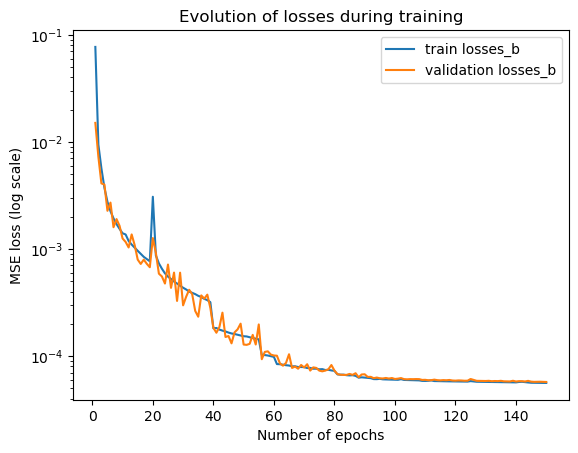

Test Loss: 0.002408


In [68]:
# load model file
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    checkpoint1_b = torch.load("model/model1_150epochs_1280kaugtraindata_batchsize256.pth", weights_only=True, map_location=torch.device('cpu'))
else:
    checkpoint1_b = torch.load("model/model1_150epochs_1280kaugtraindata_batchsize256.pth", weights_only=True)

model_t1_b = MapUpdateNetwork_1()
optimizer_t1_b = optim.Adam(model_t1_b.parameters(), lr=1e-3)

# model weights 
model_t1_b.load_state_dict(checkpoint1_b['model_state_dict'])

# optimizer state 
optimizer_t1_b.load_state_dict(checkpoint1_b['optimizer_state_dict'])

# losses
train_losses_t1_b = checkpoint1_b['train losses']
validation_losses_t1_b = checkpoint1_b['validation losses']

plt.plot(np.arange(len(train_losses_t1_b))+1, train_losses_t1_b, label='train losses_b')
plt.plot(np.arange(len(validation_losses_t1_b))+1, validation_losses_t1_b, label='validation losses_b')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.show()

# Evaluate the model on the test set
test_loss1_b = evaluate_model(model_t1_b, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss1_b:.6f}")

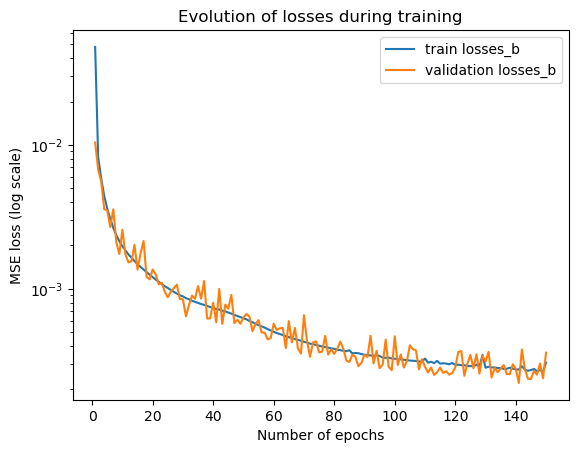

Test Loss: 0.005085


In [69]:
# load model file 
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    checkpoint2_b = torch.load("model/model2_150epochs_1280kaugtraindata_batchsize256.pth", weights_only=True, map_location=torch.device('cpu'))
else:
    checkpoint2_b = torch.load("model/model2_150epochs_1280kaugtraindata_batchsize256.pth", weights_only=True)

model_t2_b = MapUpdateNetwork_2()
optimizer_t2_b = optim.Adam(model_t2_b.parameters(), lr=1e-3)

# model weights
model_t2_b.load_state_dict(checkpoint2_b['model_state_dict'])

# optimizer state
optimizer_t2_b.load_state_dict(checkpoint2_b['optimizer_state_dict'])

# losses
train_losses_t2_b = checkpoint2_b['train losses']
validation_losses_t2_b = checkpoint2_b['validation losses']

plt.plot(np.arange(len(train_losses_t2_b))+1, train_losses_t2_b, label='train losses_b')
plt.plot(np.arange(len(validation_losses_t2_b))+1, validation_losses_t2_b, label='validation losses_b')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.show()

# Evaluate the model on the test set
test_loss2_b = evaluate_model(model_t2_b, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss2_b:.6f}")

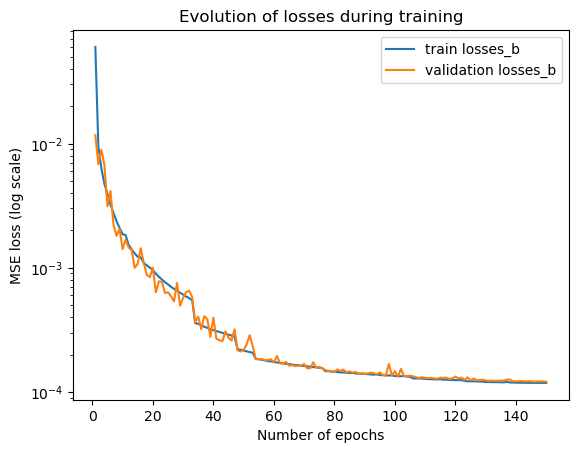

Test Loss: 0.005808


In [70]:
# load model file 
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    checkpoint3_b = torch.load("model/model3_150epochs_1280kaugtraindata_batchsize256.pth", weights_only=True, map_location=torch.device('cpu'))
else:
    checkpoint3_b = torch.load("model/model3_150epochs_1280kaugtraindata_batchsize256.pth", weights_only=True)

model_t3_b = MapUpdateNetwork_3()
optimizer_t3_b = optim.Adam(model_t3_b.parameters(), lr=1e-3)

# model weigths 
model_t3_b.load_state_dict(checkpoint3_b['model_state_dict'])

# optimizer state
optimizer_t3_b.load_state_dict(checkpoint3_b['optimizer_state_dict'])

# losses
train_losses_t3_b = checkpoint3_b['train losses']
validation_losses_t3_b = checkpoint3_b['validation losses']

plt.plot(np.arange(len(train_losses_t3_b))+1, train_losses_t3_b, label='train losses_b')
plt.plot(np.arange(len(validation_losses_t3_b))+1, validation_losses_t3_b, label='validation losses_b')
plt.legend()
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.show()

# Evaluate the model on the test set
test_loss3_b = evaluate_model(model_t3_b, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss3_b:.6f}")

### models 2.0 

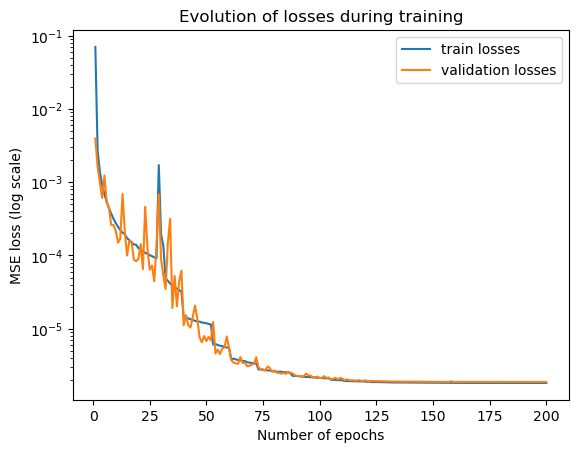

In [118]:
my_model = MapUpdateNetwork_6()
model_t6_b, train_losses_t6_b, validation_losses_t6_b = load_my_model('model/model6_200epochs_1280kaugtraindata_batchsize256.pth', my_model)

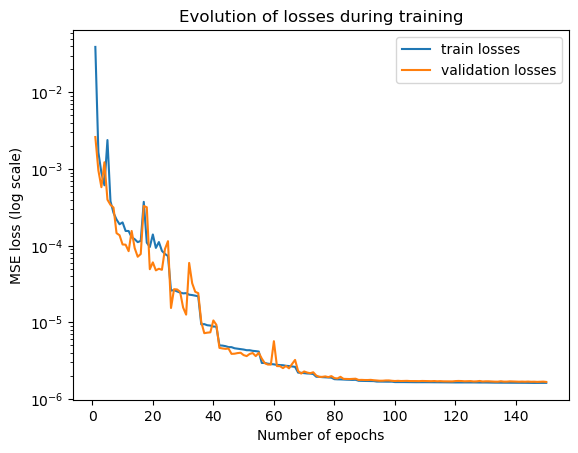

In [119]:
my_model = MapUpdateNetwork_6()
model_t6, train_losses_t6, validation_losses_t6 = load_my_model('model/model6_150epochs_1280kaugtraindata_batchsize128.pth', my_model)

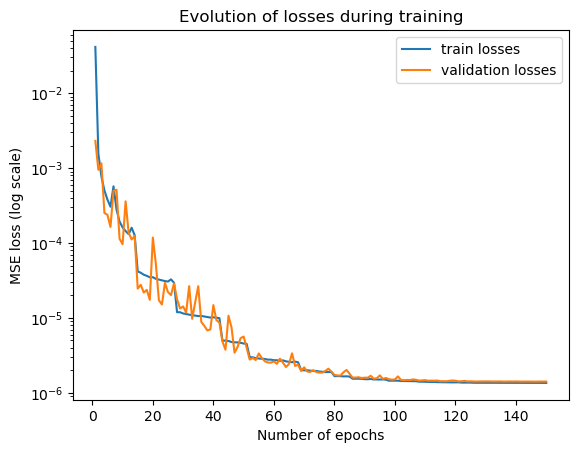

In [120]:
my_model = MapUpdateNetwork_6()
model_t6_b2, train_losses_t6_b2, validation_losses_t6_b2 = load_my_model('model/model6_150epochs_1280kaugtraindata_batchsize64.pth', my_model)

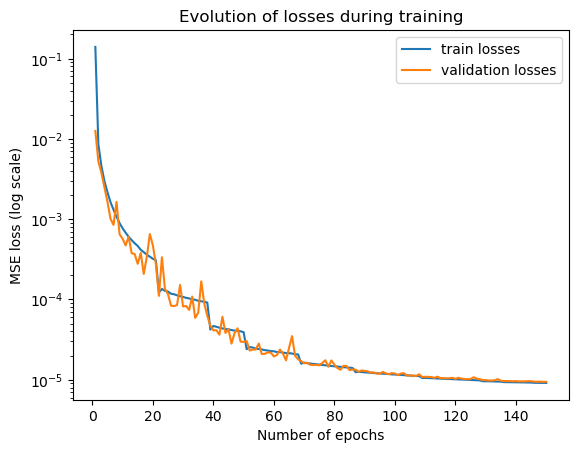

In [121]:
my_model = MapUpdateNetwork_6()
model_t6_b3, train_losses_t6_b3, validation_losses_t6_b3 = load_my_model('model/model6_150epochs_1280kaugtraindata_batchsize512.pth', my_model)

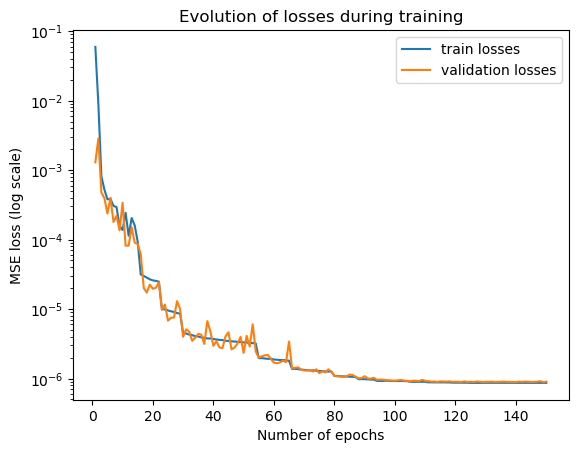

In [122]:
my_model = MapUpdateNetwork_7()
model_t7, train_losses_t7, validation_losses_t7 = load_my_model('model/model7_150epochs_1280kaugtraindata_batchsize128.pth', my_model)

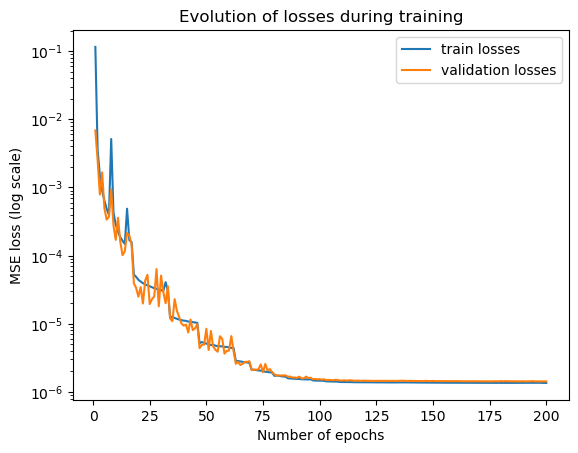

In [123]:
my_model = MapUpdateNetwork_7()
model_t7_b1, train_losses_t7_b1, validation_losses_t7_b1 = load_my_model('model/model7_200epochs_1280kaugtraindata_batchsize256.pth', my_model)

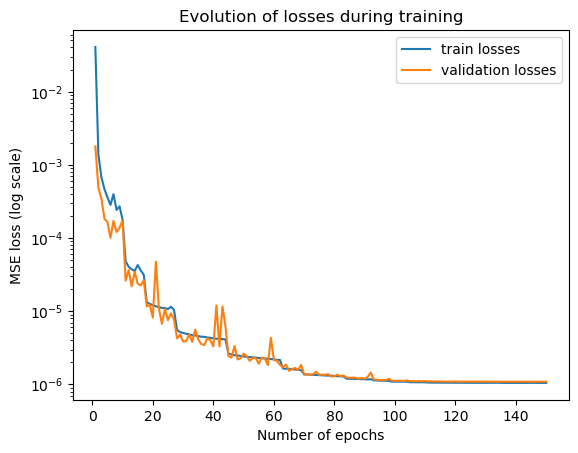

In [124]:
my_model = MapUpdateNetwork_7()
model_t7_b2, train_losses_t7_b2, validation_losses_t7_b2 = load_my_model('model/model7_150epochs_1280kaugtraindata_batchsize64.pth', my_model)

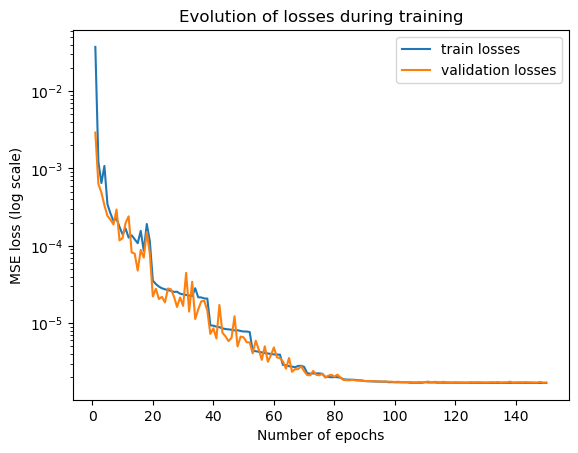

In [125]:
my_model = MapUpdateNetwork_6()
model_t6_C5_oldlr, train_losses_t6_C5_oldlr, validation_losses_t6_C5_oldlr = load_my_model('model/model6_C_150epochs_1280kaugtraindata_batchsize128.pth', my_model)

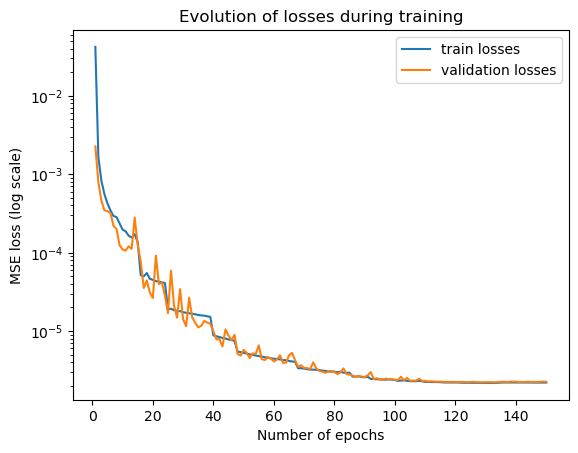

In [126]:
my_model = MapUpdateNetwork_6()
model_t6_C5bis, train_losses_t6_C5bis, validation_losses_t6_C5bis = load_my_model('model/model6_C_150epochs_1280kaugtraindata_batchsize128_bis.pth', my_model)

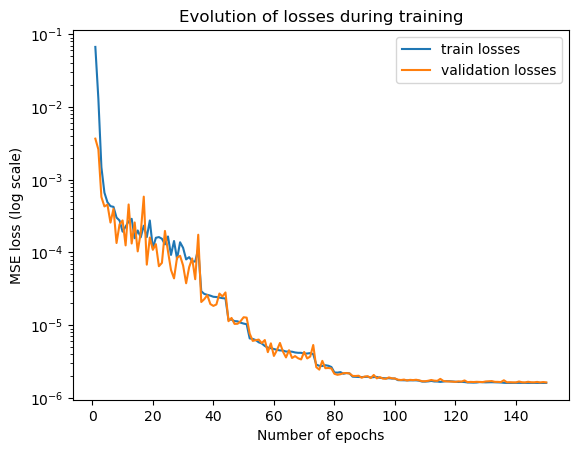

In [127]:
my_model = MapUpdateNetwork_7()
model_t7_C5_oldlr, train_losses_t7_C5_oldlr, validation_losses_t7_C5_oldlr = load_my_model('model/model7_C_150epochs_1280kaugtraindata_batchsize128.pth', my_model)

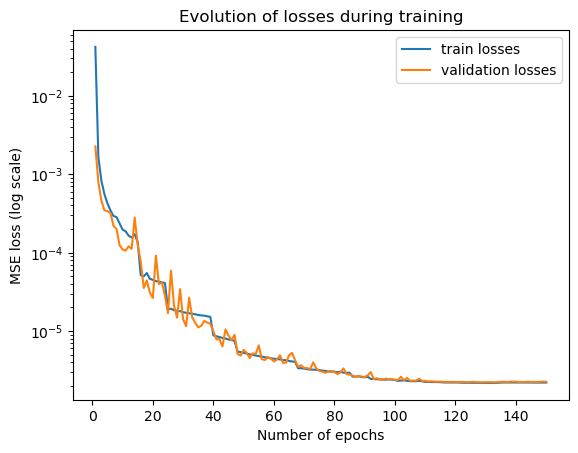

In [128]:
my_model = MapUpdateNetwork_6()
model_t6_C5_bis, train_losses_t6_C, validation_losses_t6_C = load_my_model('model/model6_C_150epochs_1280kaugtraindata_batchsize128_bis.pth', my_model)

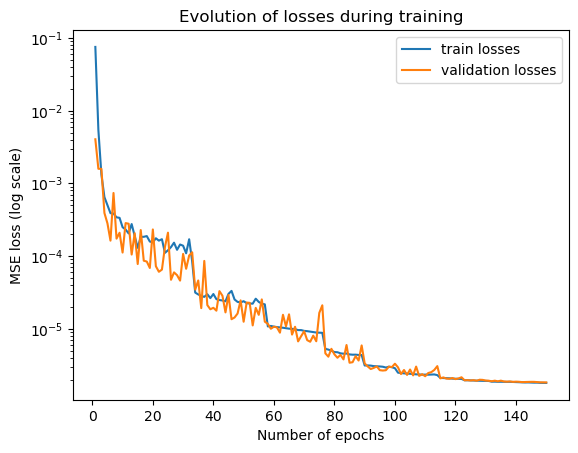

In [129]:
my_model = MapUpdateNetwork_7()
model_t7_C5bis, train_losses_t7_C5bis, validation_losses_t7_C5bis = load_my_model('model/model7_C_150epochs_1280kaugtraindata_batchsize128_bis.pth', my_model)

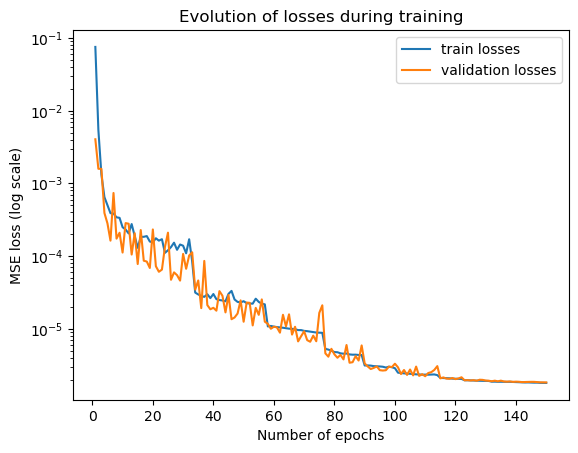

In [130]:
my_model = MapUpdateNetwork_7()
model_t7_C5_bis, train_losses_t7_C, validation_losses_t7_C = load_my_model('model/model7_C_150epochs_1280kaugtraindata_batchsize128_bis.pth', my_model)

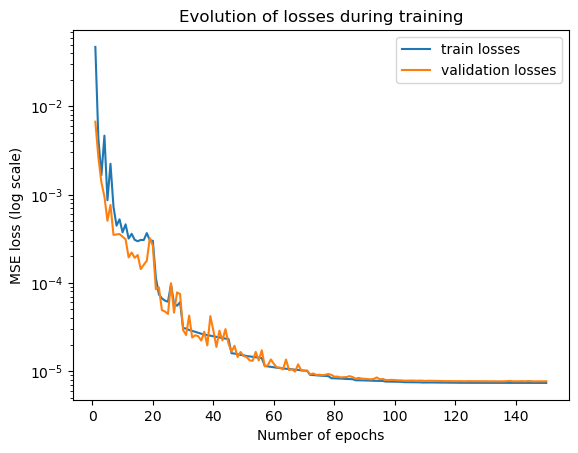

In [131]:
my_model = MapUpdateNetwork_6()
model_t6_C15_oldlr, train_losses_t6_C15_oldlr, validation_losses_t6_C15_oldlr = load_my_model('model/model6_C_15que_150epochs_1280kaugtraindata_batchsize128.pth', my_model)

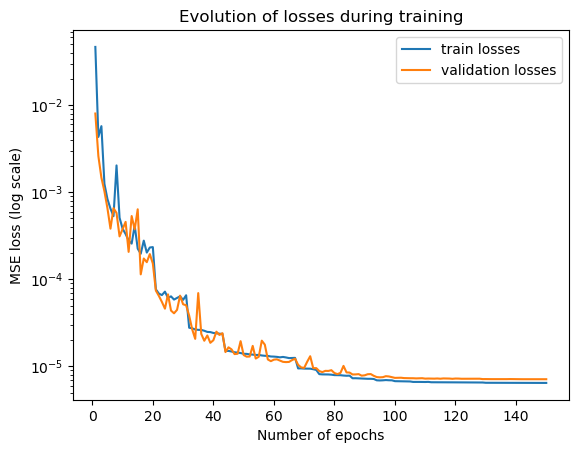

In [132]:
my_model = MapUpdateNetwork_6()
model_t6_C15, train_losses_t6_C15, validation_losses_t6_C15 = load_my_model(
    'model/model6_C_15que_150epochs_1280kaugtraindata_batchsize128_minlr8.pth', my_model)

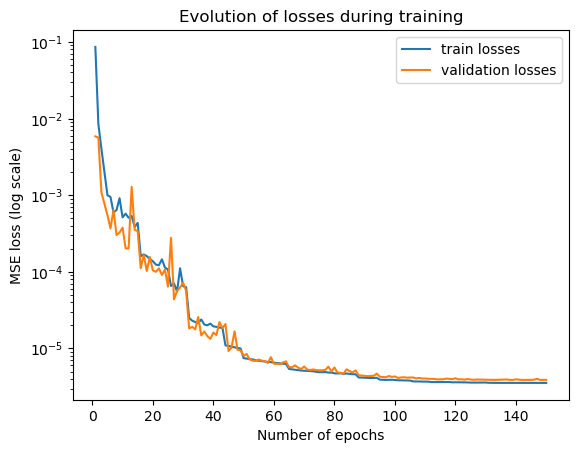

In [133]:
my_model = MapUpdateNetwork_7()
model_t7_C15_oldlr, train_losses_t7_C15_oldlr, validation_losses_t7_C15_oldlr = load_my_model('model/model7_C_15que_150epochs_1280kaugtraindata_batchsize128.pth', my_model)

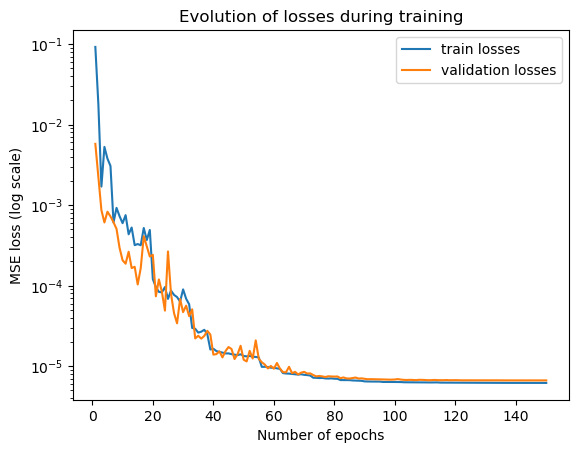

In [134]:
my_model = MapUpdateNetwork_7()
model_t7_C15, train_losses_t7_C15, validation_losses_t7_C15 = load_my_model(
    'model/model7_C_15que_150epochs_1280kaugtraindata_batchsize128_minlr8.pth', my_model)

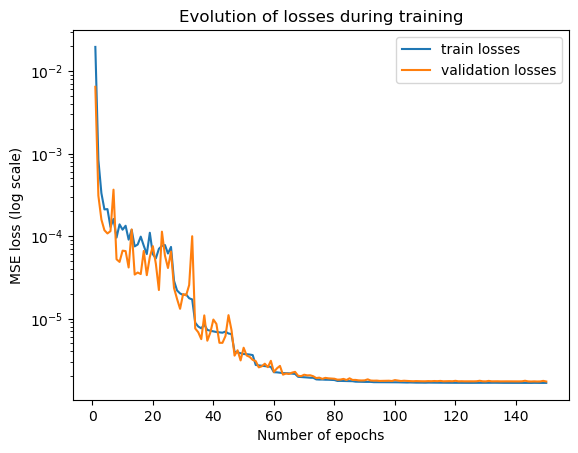

In [135]:
my_model = MapUpdateNetwork_6()
model_t6_C5b2, train_losses_t6_C5b2, validation_losses_t6_C5b2 = load_my_model('model/model6_C_5que_150epochs_1280kaugtraindata_batchsize64.pth', my_model)

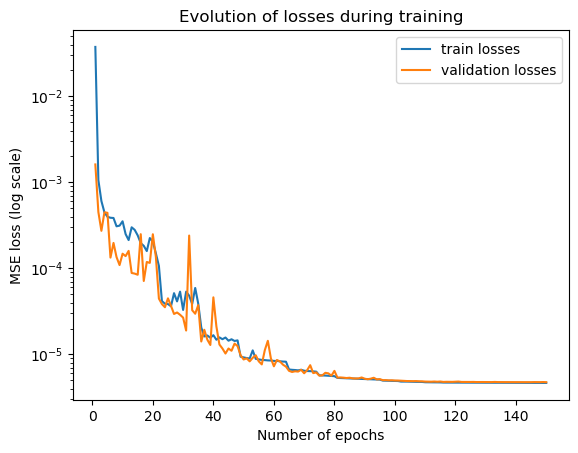

In [136]:
my_model = MapUpdateNetwork_7() 
model_t7_C5b2, train_losses_t7_C5b2, validation_losses_t7_C5b2 = load_my_model('model/model7_C_5que_150epochs_1280kaugtraindata_batchsize64.pth', my_model)

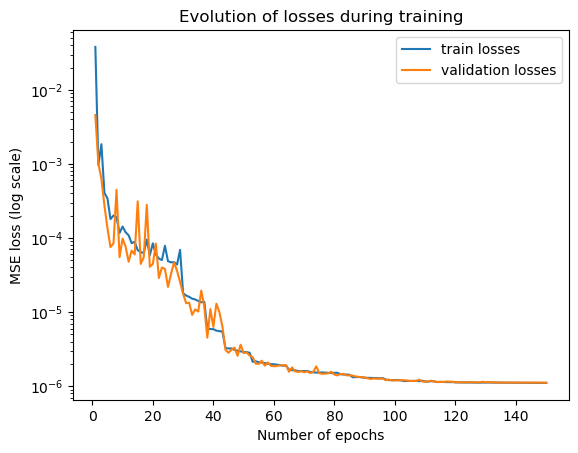

In [137]:
my_model = MapUpdateNetwork_6()
model_t6_C5, train_losses_t6_C5, validation_losses_t6_C5 = load_my_model('model/model6_C_5que_150epochs_1280kaugtraindata_batchsize128_minlr8.pth', my_model)

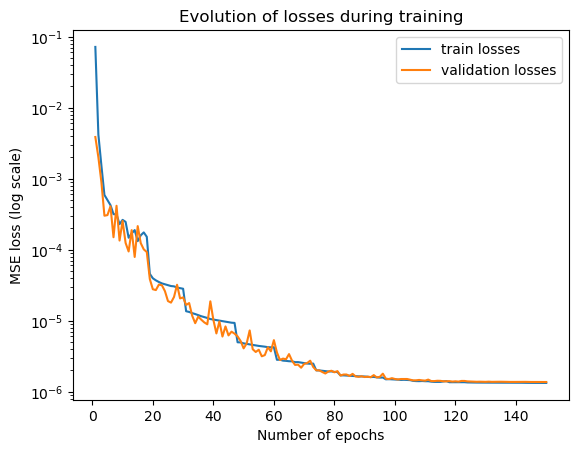

In [138]:
my_model = MapUpdateNetwork_7()
model_t7_C5, train_losses_t7_C5, validation_losses_t7_C5 = load_my_model('model/model7_C_5que_150epochs_1280kaugtraindata_batchsize128_minlr8.pth', my_model)

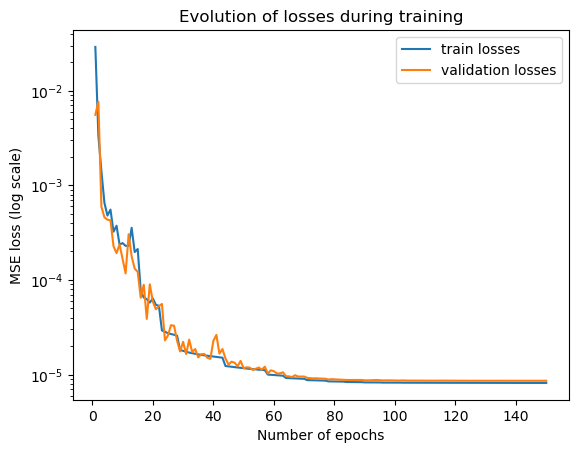

In [139]:
my_model = MapUpdateNetwork_6()
model_t6_C15b2lr, train_losses_t6_C15b2lr, validation_losses_t6_C15b2lr = load_my_model('model/model6_C_15que_150epochs_1280kaugtraindata_batchsize64_minlr8.pth', my_model)

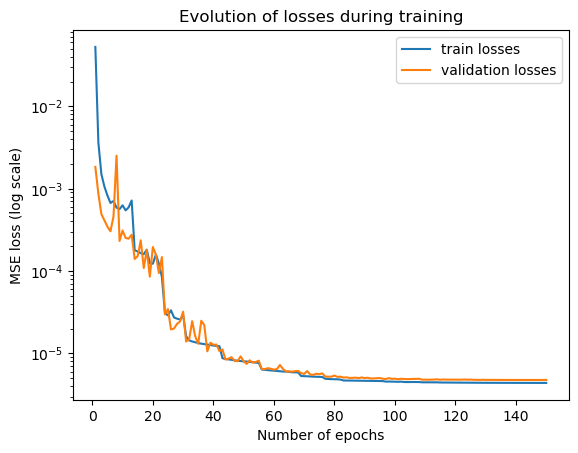

In [140]:
my_model = MapUpdateNetwork_7()
model_t7_C15b2lr, train_losses_t7_C15b2lr, validation_losses_t7_C15b2lr = load_my_model('model/model7_C_15que_150epochs_1280kaugtraindata_batchsize64_minlr8.pth', my_model)

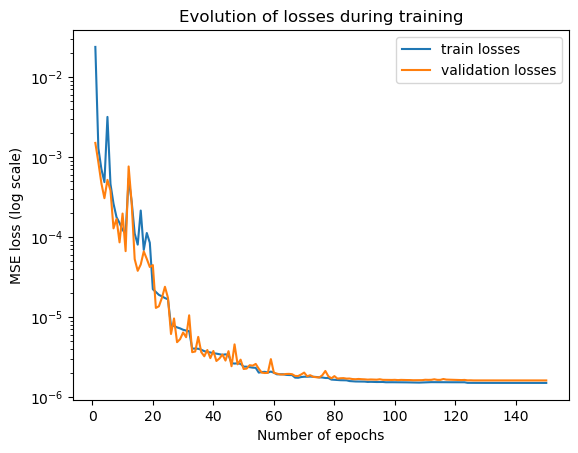

In [141]:
my_model = MapUpdateNetwork_8()
model_t8_C15, train_losses_t8_C15, validation_losses_t8_C15 = load_my_model('model/model8_C_15que_150epochs_1280kaugtraindata_batchsize128_minlr8.pth', my_model)

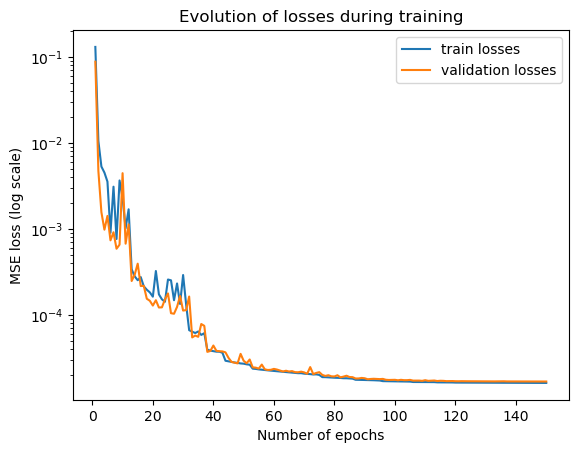

In [142]:
my_model = MapUpdateNetwork_9()
model_t9_C15, train_losses_t9_C15, validation_losses_t9_C15 = load_my_model('model/model9_C_15que_150epochs_1280kaugtraindata_batchsize128_minlr8.pth', my_model)

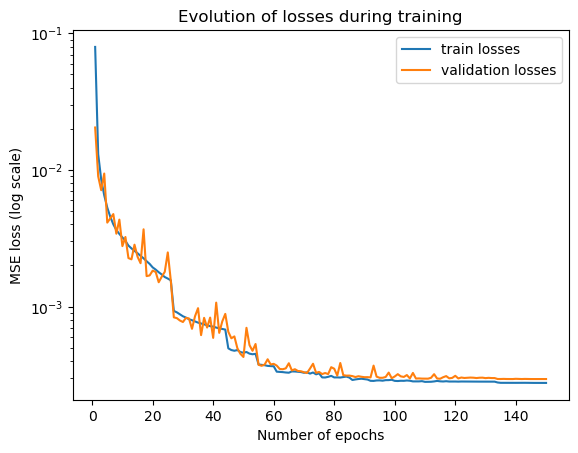

In [143]:
my_model = MapUpdateNetwork_6(out_channels_first_conv=8)
model_t6_C15_oc8, train_losses_t6_C15_oc8, validation_losses_t6_C15_oc8 = load_my_model(
    'model/model6_C_15que_150epochs_1280kaugtraindata_batchsize128_minlr8_outch8.pth', my_model)

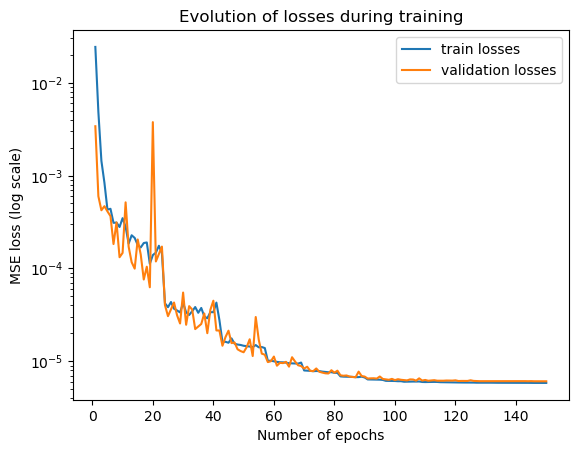

In [144]:
my_model = MapUpdateNetwork_6(out_channels_first_conv=32)
model_t6_C15_oc32, train_losses_t6_C15_oc32, validation_losses_t6_C15_oc32 = load_my_model(
    'model/model6_C_15que_150epochs_1280kaugtraindata_batchsize128_minlr8_outch32.pth', my_model)

### models 3.0

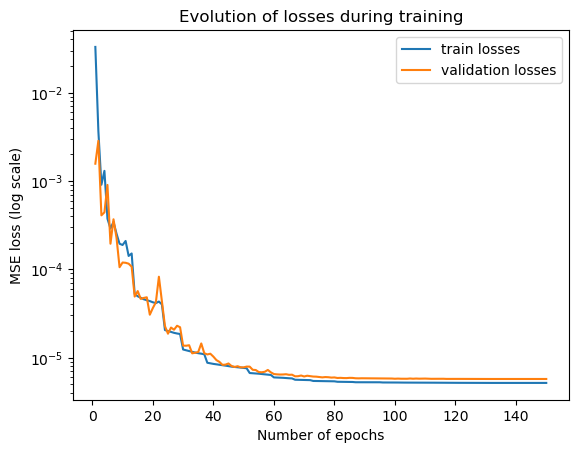

In [26]:
my_model = MapUpdateNetwork_6()
model_t6_C2to20, train_losses_t6_C2to20, validation_losses_t6_C2to20 = load_my_model(
    'model/model6_C_2to20que_150epochs_2560kaugtraindata_batchsize128_minlr8.pth', my_model)

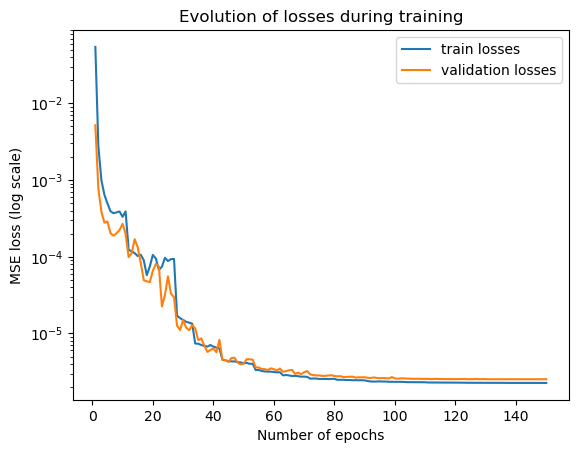

In [27]:
my_model = MapUpdateNetwork_7()
model_t7_C2to20, train_losses_t7_C2to20, validation_losses_t7_C2to20 = load_my_model(
    'model/model7_C_2to20que_150epochs_2560kaugtraindata_batchsize128_minlr8.pth', my_model)

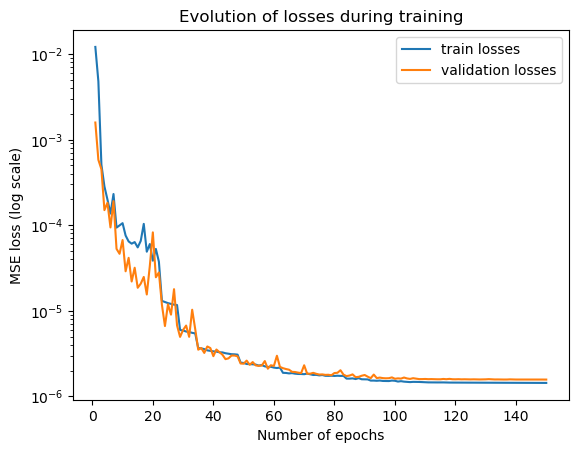

In [28]:
my_model = MapUpdateNetwork_8()
model_t8_C2to20, train_losses_t8_C2to20, validation_losses_t8_C2to20 = load_my_model(
    'model/model8_C_2to20que_150epochs_2560kaugtraindata_batchsize128_minlr8.pth', my_model)

### models 4.0

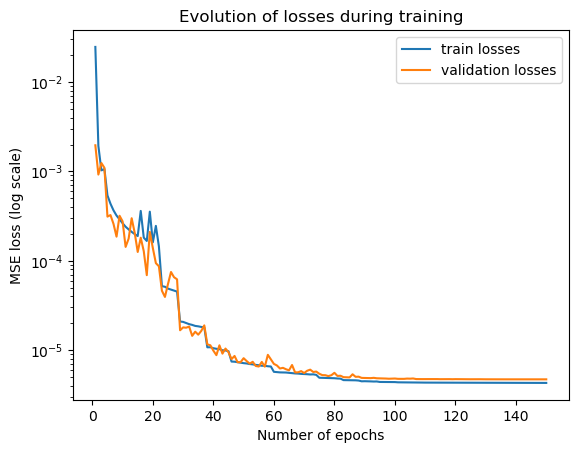

In [16]:
my_model = MapUpdateNetwork_6()
model_t6_C4_2to20, train_losses_t6_C2to20, validation_losses_t6_C2to20 = load_my_model(
    'model/model6_C4_2to20que_150epochs_2560kaugtraindata_batchsize256_minlr8.pth', my_model, plot=True)

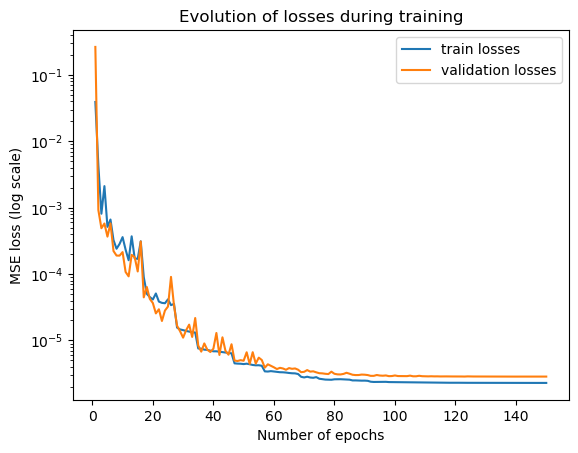

In [17]:
my_model = MapUpdateNetwork_7()
model_t7_C4_2to20, train_losses_t7_C2to20, validation_losses_t7_C2to20 = load_my_model(
    'model/model7_C4_2to20que_150epochs_2560kaugtraindata_batchsize256_minlr8.pth', my_model, plot=True)

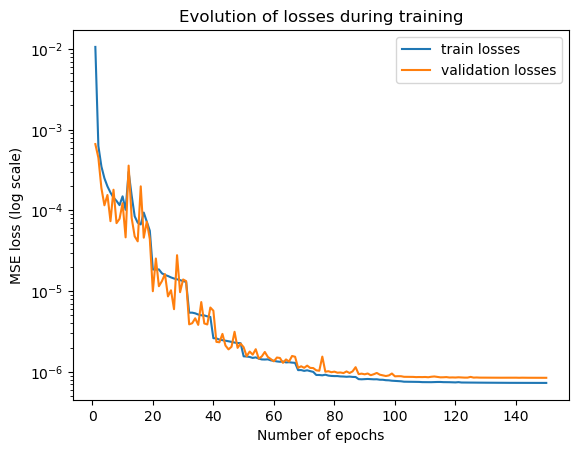

In [18]:
my_model = MapUpdateNetwork_8()
model_t8_C4_2to20, train_losses_t8_C2to20, validation_losses_t8_C2to20 = load_my_model(
    'model/model8_C4_2to20que_150epochs_2560kaugtraindata_batchsize256_minlr8.pth', my_model, plot=True)

### perf plots

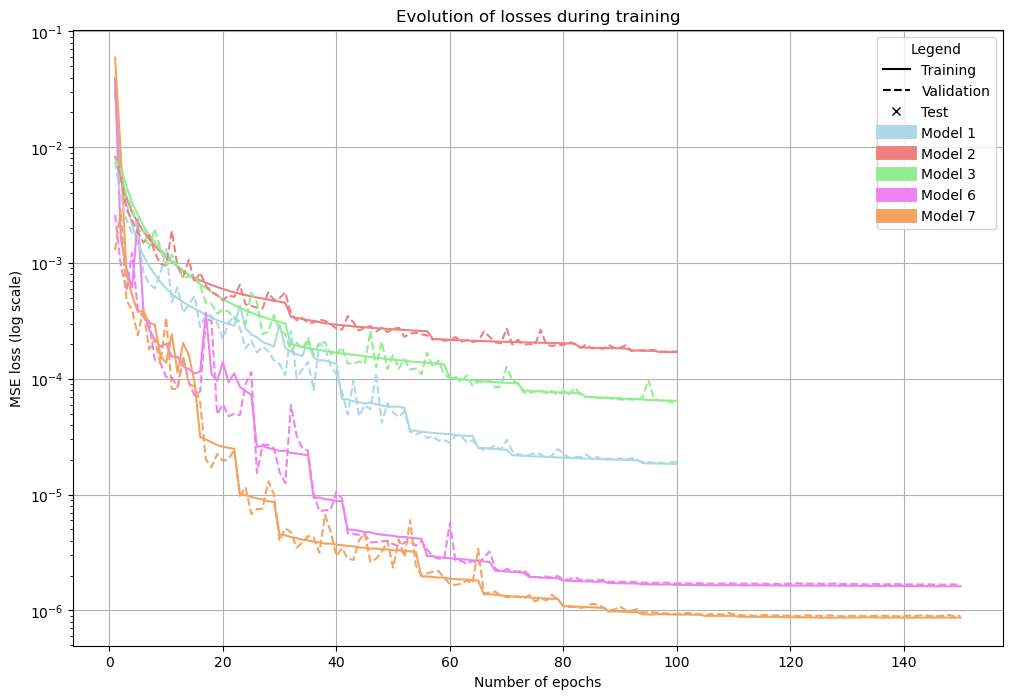

In [51]:
# Assign colors for each model
colors = {
    'model1': 'lightblue',
    'model2': 'lightcoral',
    'model3': 'lightgreen',
    'model6': 'violet',
    'model7': 'sandybrown'
}

plt.figure(figsize=(12, 8)) 

# Plot training losses 
plt.plot(np.arange(len(train_losses_t1)) + 1, train_losses_t1, color=colors['model1'], linestyle='-')
plt.plot(np.arange(len(train_losses_t2)) + 1, train_losses_t2, color=colors['model2'], linestyle='-')
plt.plot(np.arange(len(train_losses_t3)) + 1, train_losses_t3, color=colors['model3'], linestyle='-')
plt.plot(np.arange(len(train_losses_t6)) + 1, train_losses_t6, color=colors['model6'], linestyle='-')
plt.plot(np.arange(len(train_losses_t7)) + 1, train_losses_t7, color=colors['model7'], linestyle='-')
# plt.plot(np.arange(len(train_losses_t1_b)) + 1, train_losses_t1_b, color=colors['model1'], linestyle='-', linewidth = '3')
# plt.plot(np.arange(len(train_losses_t2_b)) + 1, train_losses_t2_b, color=colors['model2'], linestyle='-', linewidth = '3')
# plt.plot(np.arange(len(train_losses_t3_b)) + 1, train_losses_t3_b, color=colors['model3'], linestyle='-', linewidth = '3')
# plt.plot(np.arange(len(train_losses_t6_b)) + 1, train_losses_t6_b, color=colors['model6'], linestyle='-', linewidth = '3')
# plt.plot(np.arange(len(train_losses_t6_b2)) + 1, train_losses_t6_b2, color=colors['model6'], linestyle='-', linewidth = '3')

# Plot validation losses 
plt.plot(np.arange(len(validation_losses_t1)) + 1, validation_losses_t1, color=colors['model1'], linestyle='--')
plt.plot(np.arange(len(validation_losses_t2)) + 1, validation_losses_t2, color=colors['model2'], linestyle='--')
plt.plot(np.arange(len(validation_losses_t3)) + 1, validation_losses_t3, color=colors['model3'], linestyle='--')
plt.plot(np.arange(len(validation_losses_t6)) + 1, validation_losses_t6, color=colors['model6'], linestyle='--')
plt.plot(np.arange(len(validation_losses_t7)) + 1, validation_losses_t7, color=colors['model7'], linestyle='--')
# plt.plot(np.arange(len(validation_losses_t1_b)) + 1, validation_losses_t1_b, color=colors['model1'], linestyle='--', linewidth = '3')
# plt.plot(np.arange(len(validation_losses_t2_b)) + 1, validation_losses_t2_b, color=colors['model2'], linestyle='--', linewidth = '3')
# plt.plot(np.arange(len(validation_losses_t3_b)) + 1, validation_losses_t3_b, color=colors['model3'], linestyle='--', linewidth = '3')
# plt.plot(np.arange(len(validation_losses_t6_b)) + 1, validation_losses_t6_b, color=colors['model6'], linestyle='--', linewidth = '3')
# plt.plot(np.arange(len(validation_losses_t6_b2)) + 1, validation_losses_t6_b2, color=colors['model6'], linestyle='--', linewidth = '3')

# Plot test losses (x symbol)
# plt.plot(100, test_loss1, 'x', color=colors['model1'], markersize=10, markeredgewidth=2)
# plt.plot(100, test_loss2, 'x', color=colors['model2'], markersize=10, markeredgewidth=2)
# plt.plot(100, test_loss3, 'x', color=colors['model3'], markersize=10, markeredgewidth=2)
# plt.plot(150, test_loss6, 'x', color=colors['model6'], markersize=10, markeredgewidth=2)
# plt.plot(150, test_loss7, 'x', color=colors['model7'], markersize=10, markeredgewidth=2)
# plt.plot(150, test_loss1_b, 'x', color=colors['model1'], markersize=10, markeredgewidth=2)
# plt.plot(150, test_loss2_b, 'x', color=colors['model2'], markersize=10, markeredgewidth=2)
# plt.plot(150, test_loss3_b, 'x', color=colors['model3'], markersize=10, markeredgewidth=2)
# plt.plot(200, test_loss6_b, 'x', color=colors['model6'], markersize=10, markeredgewidth=2)
# plt.plot(150, test_loss6_b2, 'x', color=colors['model6'], markersize=10, markeredgewidth=2)

# Create custom legend entries
train_line = mlines.Line2D([], [], color='black', linestyle='-', label='Training')
validation_line = mlines.Line2D([], [], color='black', linestyle='--', label='Validation')
test_marker = mlines.Line2D([], [], color='black', marker='x', linestyle='', label='Test')
# batchsize_line = mlines.Line2D([], [], color='black', linestyle='-', label='batchize=1024', linewidth = '3')

model1_patch = mlines.Line2D([], [], color=colors['model1'], label='Model 1', linestyle='-', linewidth = '10')
model2_patch = mlines.Line2D([], [], color=colors['model2'], label='Model 2', linestyle='-', linewidth = '10')
model3_patch = mlines.Line2D([], [], color=colors['model3'], label='Model 3', linestyle='-', linewidth = '10')
model6_patch = mlines.Line2D([], [], color=colors['model6'], label='Model 6', linestyle='-', linewidth = '10')
model7_patch = mlines.Line2D([], [], color=colors['model7'], label='Model 7', linestyle='-', linewidth = '10')

# Add the legend
plt.legend(handles=[train_line, validation_line, test_marker, model1_patch, model2_patch, model3_patch, model6_patch, model7_patch],
           loc='upper right', title='Legend')

# Add labels and title
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.grid()

# Display the plot
plt.show()

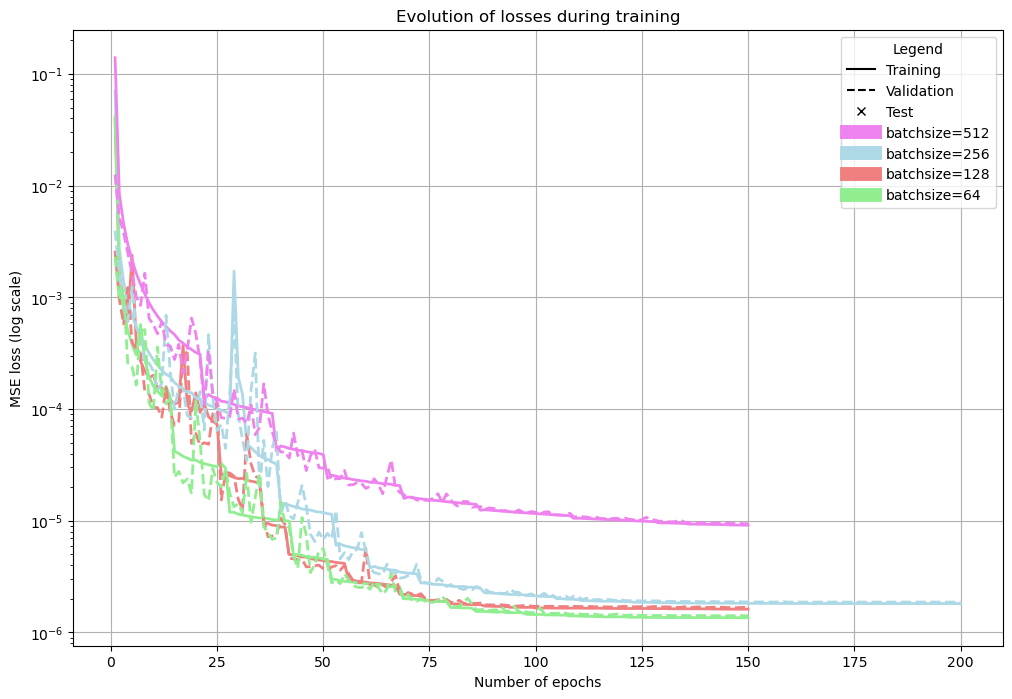

In [52]:
colors = {
    'batchsize=256': 'lightblue',
    'batchsize=128': 'lightcoral',
    'batchsize=64': 'lightgreen',
    'batchsize=512': 'violet',
}

plt.figure(figsize=(12, 8))

plt.plot(np.arange(len(train_losses_t6)) + 1, train_losses_t6, color=colors['batchsize=128'], linestyle='-', linewidth = '2')
plt.plot(np.arange(len(train_losses_t6_b)) + 1, train_losses_t6_b, color=colors['batchsize=256'], linestyle='-', linewidth = '2')
plt.plot(np.arange(len(train_losses_t6_b2)) + 1, train_losses_t6_b2, color=colors['batchsize=64'], linestyle='-', linewidth = '2')
plt.plot(np.arange(len(train_losses_t6_b3)) + 1, train_losses_t6_b3, color=colors['batchsize=512'], linestyle='-', linewidth = '2')

plt.plot(np.arange(len(validation_losses_t6)) + 1, validation_losses_t6, color=colors['batchsize=128'], linestyle='--', linewidth = '2')
plt.plot(np.arange(len(validation_losses_t6_b)) + 1, validation_losses_t6_b, color=colors['batchsize=256'], linestyle='--', linewidth = '2')
plt.plot(np.arange(len(validation_losses_t6_b2)) + 1, validation_losses_t6_b2, color=colors['batchsize=64'], linestyle='--', linewidth = '2')
plt.plot(np.arange(len(validation_losses_t6_b3)) + 1, validation_losses_t6_b3, color=colors['batchsize=512'], linestyle='--', linewidth = '2')

# plt.plot(150, test_loss6, 'x', color=colors['batchsize=128'], markersize=10, markeredgewidth=2)
# plt.plot(200, test_loss6_b, 'x', color=colors['batchsize=256'], markersize=10, markeredgewidth=2)
# plt.plot(150, test_loss6_b2, 'x', color=colors['batchsize=64'], markersize=10, markeredgewidth=2)
# plt.plot(150, test_loss6_b3, 'x', color=colors['batchsize=512'], markersize=10, markeredgewidth=2)

# Create custom legend entries
train_line = mlines.Line2D([], [], color='black', linestyle='-', label='Training')
validation_line = mlines.Line2D([], [], color='black', linestyle='--', label='Validation')
test_marker = mlines.Line2D([], [], color='black', marker='x', linestyle='', label='Test')

batchsize1_patch = mlines.Line2D([], [], color=colors['batchsize=256'], label='batchsize=256', linestyle='-', linewidth = '10')
batchsize2_patch = mlines.Line2D([], [], color=colors['batchsize=128'], label='batchsize=128', linestyle='-', linewidth = '10')
batchsize3_patch = mlines.Line2D([], [], color=colors['batchsize=64'], label='batchsize=64', linestyle='-', linewidth = '10')
batchsize4_patch = mlines.Line2D([], [], color=colors['batchsize=512'], label='batchsize=512', linestyle='-', linewidth = '10')

# Add the legend
plt.legend(handles=[train_line, validation_line, test_marker, batchsize4_patch, batchsize1_patch, batchsize2_patch, batchsize3_patch],
           loc='upper right', title='Legend')

# Add labels and title
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.grid()

# Display the plot
plt.show()



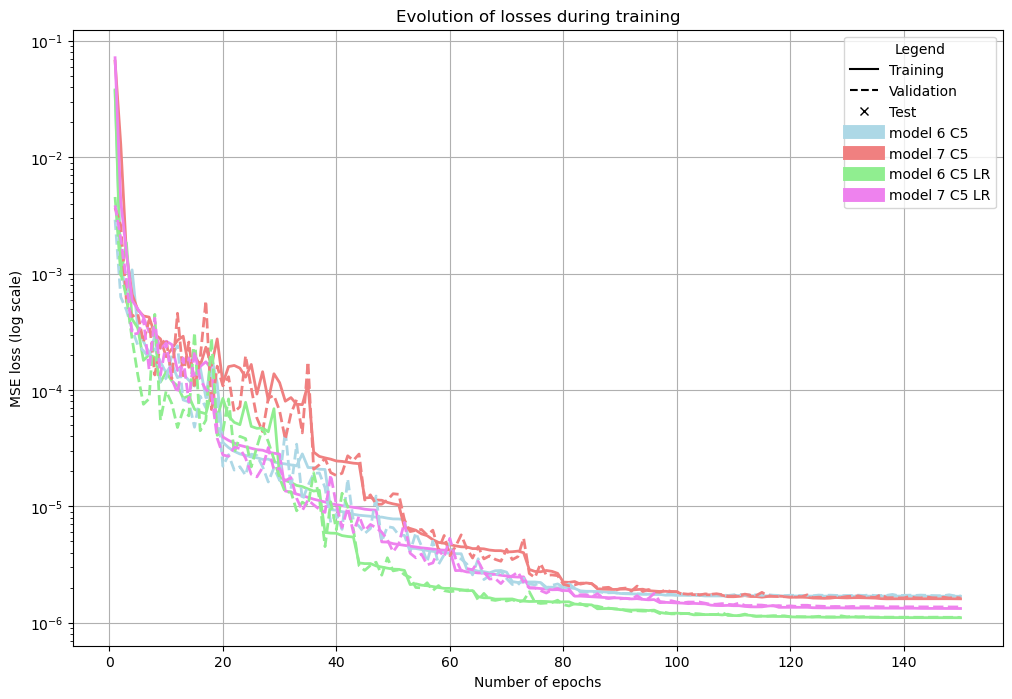

In [53]:
colors = {
    'model 6 C5': 'lightblue',
    'model 7 C5': 'lightcoral',
    'model 6 C5 LR': 'lightgreen',
    'model 7 C5 LR': 'violet',
}

plt.figure(figsize=(12, 8))

plt.plot(np.arange(len(train_losses_t6_C5)) + 1, train_losses_t6_C5, color=colors['model 6 C5'], linestyle='-', linewidth = '2')
plt.plot(np.arange(len(train_losses_t7_C5)) + 1, train_losses_t7_C5, color=colors['model 7 C5'], linestyle='-', linewidth = '2')
plt.plot(np.arange(len(train_losses_t6_C5lr)) + 1, train_losses_t6_C5lr, color=colors['model 6 C5 LR'], linestyle='-', linewidth = '2')
plt.plot(np.arange(len(train_losses_t7_C5lr)) + 1, train_losses_t7_C5lr, color=colors['model 7 C5 LR'], linestyle='-', linewidth = '2')

plt.plot(np.arange(len(validation_losses_t6_C5)) + 1, validation_losses_t6_C5, color=colors['model 6 C5'], linestyle='--', linewidth = '2')
plt.plot(np.arange(len(validation_losses_t7_C5)) + 1, validation_losses_t7_C5, color=colors['model 7 C5'], linestyle='--', linewidth = '2')
plt.plot(np.arange(len(validation_losses_t6_C5lr)) + 1, validation_losses_t6_C5lr, color=colors['model 6 C5 LR'], linestyle='--', linewidth = '2')
plt.plot(np.arange(len(validation_losses_t7_C5lr)) + 1, validation_losses_t7_C5lr, color=colors['model 7 C5 LR'], linestyle='--', linewidth = '2')

# plt.plot(150, test_loss6, 'x', color=colors['batchsize=128'], markersize=10, markeredgewidth=2)
# plt.plot(200, test_loss6_b, 'x', color=colors['batchsize=256'], markersize=10, markeredgewidth=2)
# plt.plot(150, test_loss6_b2, 'x', color=colors['batchsize=64'], markersize=10, markeredgewidth=2)
# plt.plot(150, test_loss6_b3, 'x', color=colors['batchsize=512'], markersize=10, markeredgewidth=2)

# Create custom legend entries
train_line = mlines.Line2D([], [], color='black', linestyle='-', label='Training')
validation_line = mlines.Line2D([], [], color='black', linestyle='--', label='Validation')
test_marker = mlines.Line2D([], [], color='black', marker='x', linestyle='', label='Test')

batchsize1_patch = mlines.Line2D([], [], color=colors['model 6 C5'], label='model 6 C5', linestyle='-', linewidth = '10')
batchsize2_patch = mlines.Line2D([], [], color=colors['model 7 C5'], label='model 7 C5', linestyle='-', linewidth = '10')
batchsize3_patch = mlines.Line2D([], [], color=colors['model 6 C5 LR'], label='model 6 C5 LR', linestyle='-', linewidth = '10')
batchsize4_patch = mlines.Line2D([], [], color=colors['model 7 C5 LR'], label='model 7 C5 LR', linestyle='-', linewidth = '10')

# Add the legend
plt.legend(handles=[train_line, validation_line, test_marker, batchsize1_patch, batchsize2_patch, batchsize3_patch, batchsize4_patch],
           loc='upper right', title='Legend')

# Add labels and title
plt.xlabel('Number of epochs')
plt.ylabel('MSE loss (log scale)')
plt.yscale('log')
plt.title("Evolution of losses during training")
plt.grid()

# Display the plot
plt.show()

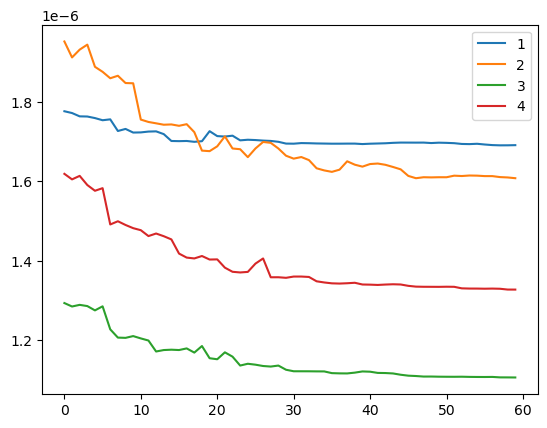

In [54]:
plt.plot(train_losses_t6_C5[90:], label='1')
plt.plot(train_losses_t7_C5[90:], label='2')
plt.plot(train_losses_t6_C5lr[90:], label='3')
plt.plot(train_losses_t7_C5lr[90:], label='4')
plt.legend()
plt.show()


## H) Postprocess

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [65]:
def get_loader(dataset_files:list, batch_size = 512, shuffle = False, print_description = False):
    # Load the saved data from a .pth file using PyTorch
    my_loaded_data = concatenate_dataset(dataset_files) 
    # The 'weights_only=True' argument ensures that only the model weights (not the entire model) are loaded

    # Access the tensors and the description from the loaded data
    my_input = my_loaded_data["train_input"]  # The input data for training
    my_label = my_loaded_data["train_label"]  # The corresponding labels for the training data
    loaded_description = my_loaded_data["description"]  # The description or metadata associated with the data

    if print_description:
        print(loaded_description)

    my_X = my_input
    my_Y = my_label

    my_dataset = TensorDataset(my_X, my_Y)
    my_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=shuffle)

    return (my_loader)

### a) Evaluate 1 model

In [80]:
model_for_evaluation = model_t8_C4_2to20
test_loader_of_model_for_evaluation = get_loader(['dataset/emgALLrat/og_C4_2to20que_multikcomb_rat5_emgALL.pth'])

# Evaluate the model on the test set
test_loss = evaluate_model(model_for_evaluation, test_loader_of_model_for_evaluation, custom_loss, device)
print(f"Test Loss: {test_loss:.8f}")

Test Loss: 0.00000082


#### Visualize results

In [57]:
retrieved_X = torch.cat([batch[0] for batch in test_loader_of_model_for_evaluation], dim=0)
retrieved_Y = torch.cat([batch[1] for batch in test_loader_of_model_for_evaluation], dim=0)

model_for_evaluation.eval()
indices = torch.randperm(len(retrieved_X))[:20]
outputs = model_for_evaluation(*torch.split(retrieved_X[indices], 1, dim=1))

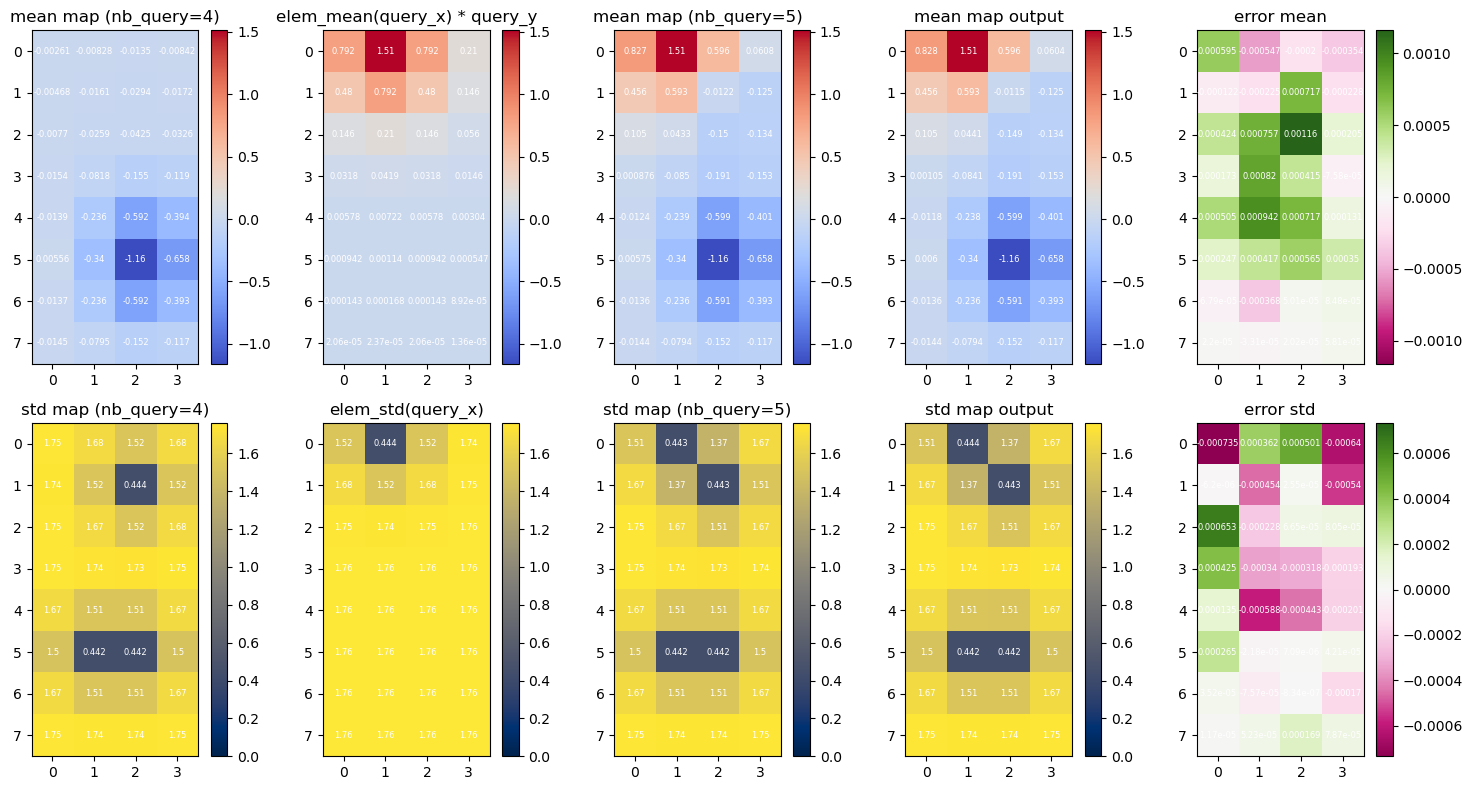

In [58]:
compare_output_label(train_input=retrieved_X[indices], train_label=retrieved_Y[indices], output=outputs.detach(), comb_idx=4, values=True)

In [60]:
plot_combinations(train_input=retrieved_X[indices], train_label=retrieved_Y[indices], output=outputs.detach(), comb_idx_range=(0, 19), values=True)

interactive(children=(IntSlider(value=0, description='Comb Index', max=19), Output()), _dom_classes=('widget-i…

### c) Compare models with various datasets 

In [81]:
def compare_models(models, dataset_files, models_labels, datasets_labels, title="Model Comparison", figsize=(10, 6), width=0.15):
    """
    Creates a grouped bar chart comparing the results of models across multiple datasets.

    Arguments:
        - models (list):
        - dataset_files (list):
        - model_labels (list of str): List of labels for the models.
        - dataset_labels (list of str): List of labels for the datasets.
        - title (str): Title for the chart.
        - figsize (tuple): Size of the figure (width, height).

    Returns:
        - None: Displays the chart.
    """
    # Set the positions for the dataset labels along the x-axis
    x = np.arange(len(datasets_labels))  # Position of datasets on the x-axis
    num_models = len(models_labels)  # Number of models

    # Initialize the figure for plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Variable to shift the bars for each model
    multiplier = 0

    models_results = []

    for dataset_file in dataset_files:
        my_test_loader = get_loader(dataset_files=[dataset_file])
        results_for_my_test_loader = []
        for model in models:
            results_for_my_test_loader.append(evaluate_model(model=model, test_loader=my_test_loader, 
                                                             criterion_function=custom_loss, device=device))
        models_results.append(results_for_my_test_loader)
        
    
    # Loop over each model and add bars for each dataset
    for model_index, model_label in enumerate(models_labels):
        # Extract the results for the current model from each dataset
        model_results = [models_results[dataset_idx][model_index] for dataset_idx in range(len(datasets_labels))]
        
        # Offset to position the bars correctly for each model
        offset = width * multiplier
        
        # Plot the bars for the current model, grouped by dataset
        rects = ax.bar(x + offset, model_results, width, label=model_label)
        
        # Add the values (loss) on top of the bars, rounded to 3 significant digits
        ax.bar_label(
            rects,
            labels=[f"{value:.3g}" for value in model_results],  # Format to 3 significant digits
            padding=3, 
            rotation=90 
        )
        
        # Increment the multiplier to shift the next model's bars
        multiplier += 1

    # Add labels, title, and other customizations
    ax.set_ylabel('Loss (or other metric)')  # Y-axis label
    ax.set_title(title)  # Title of the chart
    ax.set_xticks(x + width * (num_models - 1) / 2)  # Set x-tick positions in the middle of the grouped bars
    ax.set_xticklabels(datasets_labels, rotation=45)  # Set dataset labels on the x-axis, rotated for better visibility
    ax.legend(title="Models", loc='upper left', ncols=3)  # Add a legend for models
    ax.set_yscale('log')  # Logarithmic scale for y-axis
    ax.set_ylim(0, 10*max(max(models_results[dataset_idx]) for dataset_idx in range(len(datasets_labels))))  # Set the y-axis range based on the data

    plt.tight_layout()  # Adjust layout to make sure everything fits well
    plt.show()  # Display the chart

    return(models_results)



 C:\Users\deleu\AppData\Local\Temp\ipykernel_28892\1928475976.py:66: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


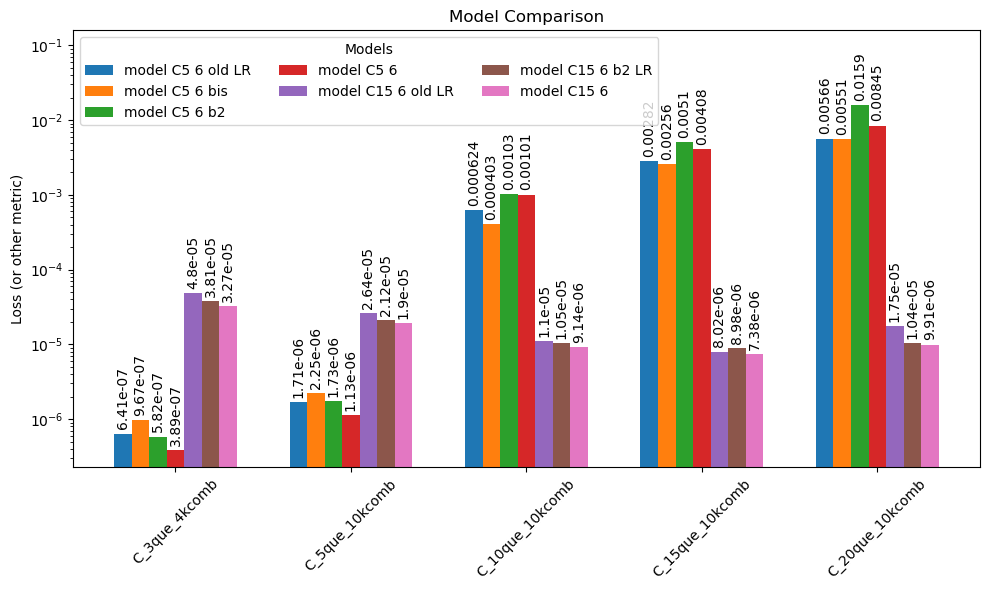

In [88]:
models = [# model_t6,
          # model_t6_b2, 
          # model_t7,
        #   model_t7_b2,
          model_t6_C5_oldlr,
          model_t6_C5bis,
          # model_t7_C5,
          model_t6_C5b2,
          # model_t7_C5b2, 
          model_t6_C5,
          # model_t7_C5lr,
          model_t6_C15_oldlr,
          # model_t7_C15,
          model_t6_C15b2lr,
          model_t6_C15,
          ]
models_labels = [#'model A5 6',
                #  'model A5 6 b2',
                 #'model A5 7',
                #  'model A5 7 b2',
                 'model C5 6 old LR',
                 'model C5 6 bis',
                #  'model C5 7',
                 'model C5 6 b2',
                #  'model C5 7 b2',
                 'model C5 6',
                #  'model C5 7 LR',
                 'model C15 6 old LR',
                #  'model C15 7',
                 'model C15 6 b2 LR',
                 'model C15 6',
                 ]
datasets_files = [# 'dataset/emgALL/og_A_3que_4kcomb_rat5_emgALL.pth',
                  # 'dataset/emgALL/og_A_5que_10kcomb_rat5_emgALL.pth',
                  # 'dataset/emgALL/og_A_10que_10kcomb_rat5_emgALL.pth',
                  'dataset/emgALL/og_C_3que_4kcomb_rat5_emgALL.pth',
                  'dataset/emgALL/og_C_5que_10kcomb_rat5_emgALL.pth',
                  'dataset/emgALL/og_C_10que_10kcomb_rat5_emgALL.pth',
                  'dataset/emgALL/og_C_15que_10kcomb_rat5_emgALL.pth',
                  'dataset/emgALL/og_C_20que_10kcomb_rat5_emgALL.pth',
                 ]
datasets_labels = [# 'A_3que_4kcomb',
                   # 'A_5que_10kcomb',
                   # 'A_10que_10kcomb',
                   'C_3que_4kcomb',
                   'C_5que_10kcomb',
                   'C_10que_10kcomb',
                   'C_15que_10kcomb',
                   'C_20que_10kcomb',
                   ]

my_models_results = compare_models(models, datasets_files, models_labels, datasets_labels, width=0.1)

 C:\Users\deleu\AppData\Local\Temp\ipykernel_28892\1928475976.py:66: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


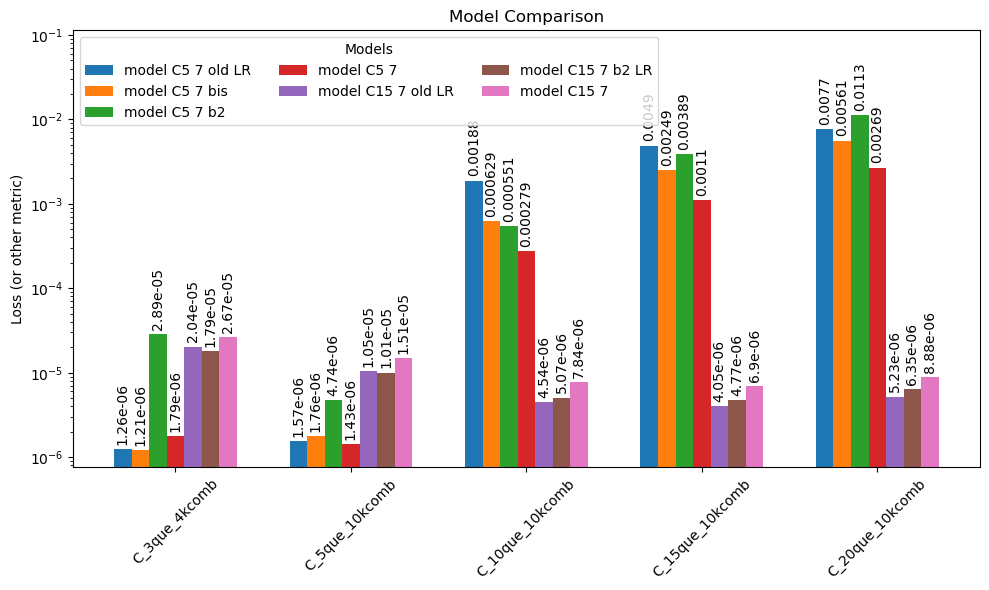

In [87]:
models = [# model_t6,
          # model_t6_b2, 
          # model_t7,
        #   model_t7_b2,
        #   model_t6_C5,
        #   model_t6_C5bis,
          model_t7_C5_oldlr,
          model_t7_C5bis,
        #   model_t6_C5b2,
          model_t7_C5b2, 
        #   model_t6_C5lr,
          model_t7_C5,
        #   model_t6_C15,
          model_t7_C15_oldlr,
        #   model_t6_C15b2lr,
          model_t7_C15b2lr,
          model_t7_C15,
          ]
models_labels = [#'model A5 6',
                #  'model A5 6 b2',
                 #'model A5 7',
                #  'model A5 7 b2',
                #  'model C5 6',
                #  'model C5 6 bis'
                 'model C5 7 old LR',
                 'model C5 7 bis',
                #  'model C5 6 b2',
                 'model C5 7 b2',
                #  'model C5 6 LR',
                 'model C5 7',
                #  'model C15 6',
                 'model C15 7 old LR',
                #  'model C15 6 b2 LR',
                 'model C15 7 b2 LR',
                 'model C15 7',
                 ]
datasets_files = [# 'dataset/emgALL/og_A_3que_4kcomb_rat5_emgALL.pth',
                #  'dataset/emgALL/og_A_5que_10kcomb_rat5_emgALL.pth',
                #  'dataset/emgALL/og_A_10que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_3que_4kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_5que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_10que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_15que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_20que_10kcomb_rat5_emgALL.pth',
                ]
datasets_labels = [# 'A_3que_4kcomb',
                  #  'A_5que_10kcomb',
                  #  'A_10que_10kcomb',
                   'C_3que_4kcomb',
                   'C_5que_10kcomb',
                   'C_10que_10kcomb',
                   'C_15que_10kcomb',
                   'C_20que_10kcomb',
                   ]

my_models_results = compare_models(models, datasets_files, models_labels, datasets_labels, width=0.1)

 C:\Users\deleu\AppData\Local\Temp\ipykernel_28892\4137053676.py:67: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


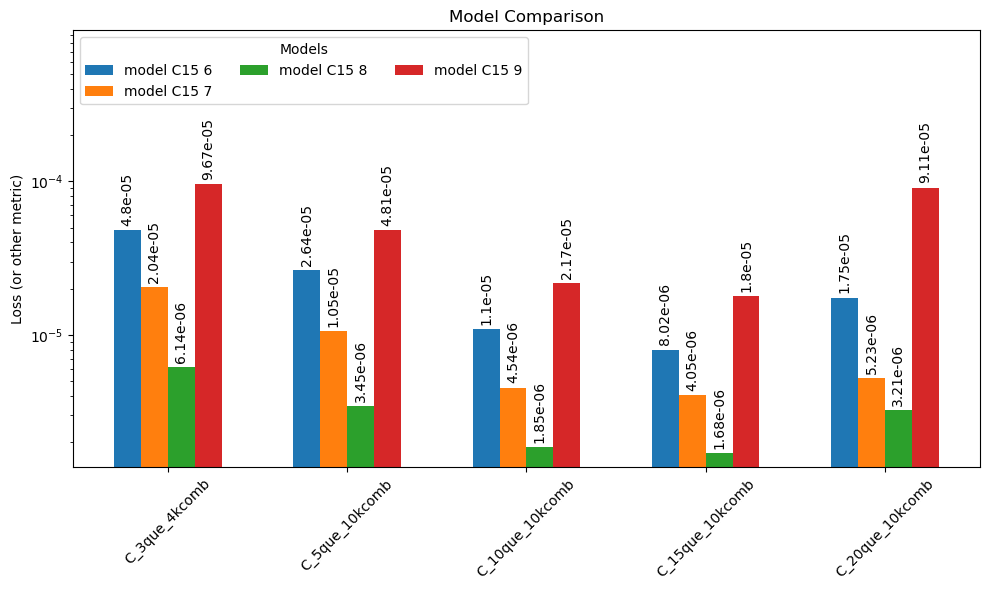

In [62]:
models = [model_t6_C15,
          model_t7_C15,
          model_t8_C15,
          model_t9_C15,
          ]
models_labels = ['model C15 6',
                 'model C15 7',
                 'model C15 8',
                 'model C15 9'
                 ]
datasets_files = [# 'dataset/emgALL/og_A_3que_4kcomb_rat5_emgALL.pth',
                 # 'dataset/emgALL/og_A_5que_10kcomb_rat5_emgALL.pth',
                 # 'dataset/emgALL/og_A_10que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_3que_4kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_5que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_10que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_15que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_20que_10kcomb_rat5_emgALL.pth',
                ]
datasets_labels = [# 'A_3que_4kcomb',
                   # 'A_5que_10kcomb',
                   # 'A_10que_10kcomb',
                   'C_3que_4kcomb',
                   'C_5que_10kcomb',
                   'C_10que_10kcomb',
                   'C_15que_10kcomb',
                   'C_20que_10kcomb',
                   ]

my_models_results = compare_models(models, datasets_files, models_labels, datasets_labels)

 C:\Users\deleu\AppData\Local\Temp\ipykernel_30256\1928475976.py:66: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


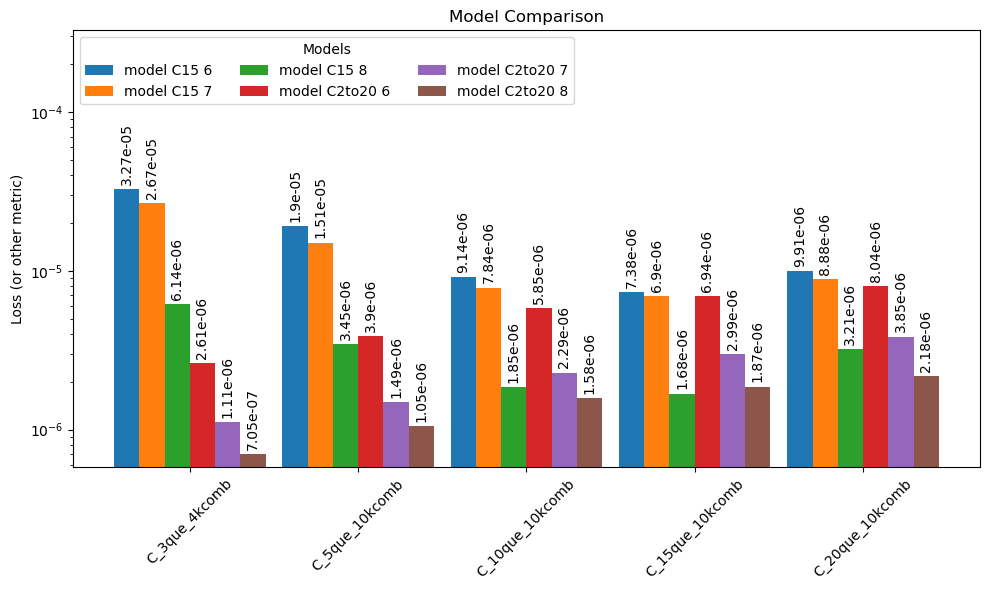

In [151]:
models = [model_t6_C15,
          model_t7_C15,
          model_t8_C15,
          model_t6_C2to20,
          model_t7_C2to20,
          model_t8_C2to20,
          ]
models_labels = ['model C15 6',
                 'model C15 7',
                 'model C15 8',
                 'model C2to20 6',
                 'model C2to20 7',
                 'model C2to20 8',
                 ]
datasets_files = [# 'dataset/emgALL/og_A_3que_4kcomb_rat5_emgALL.pth',
                 # 'dataset/emgALL/og_A_5que_10kcomb_rat5_emgALL.pth',
                 # 'dataset/emgALL/og_A_10que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_3que_4kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_5que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_10que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_15que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_20que_10kcomb_rat5_emgALL.pth',
                ]
datasets_labels = [# 'A_3que_4kcomb',
                   # 'A_5que_10kcomb',
                   # 'A_10que_10kcomb',
                   'C_3que_4kcomb',
                   'C_5que_10kcomb',
                   'C_10que_10kcomb',
                   'C_15que_10kcomb',
                   'C_20que_10kcomb',
                   ]

my_models_results = compare_models(models, datasets_files, models_labels, datasets_labels)

 C:\Users\deleu\AppData\Local\Temp\ipykernel_28892\4137053676.py:67: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


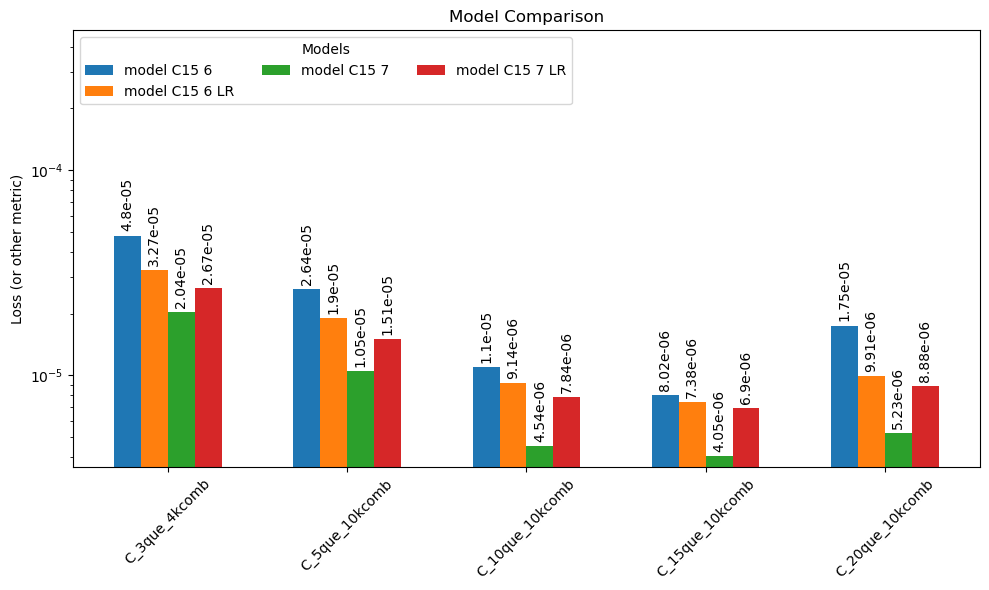

In [72]:
models = [model_t6_C15,
          model_t6_C15_lr,
          model_t7_C15,
          model_t7_C15_lr,
          ]
models_labels = ['model C15 6',
                 'model C15 6 LR',
                 'model C15 7',
                 'model C15 7 LR'
                 ]
datasets_files = [# 'dataset/emgALL/og_A_3que_4kcomb_rat5_emgALL.pth',
                 # 'dataset/emgALL/og_A_5que_10kcomb_rat5_emgALL.pth',
                 # 'dataset/emgALL/og_A_10que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_3que_4kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_5que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_10que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_15que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_20que_10kcomb_rat5_emgALL.pth',
                ]
datasets_labels = [# 'A_3que_4kcomb',
                   # 'A_5que_10kcomb',
                   # 'A_10que_10kcomb',
                   'C_3que_4kcomb',
                   'C_5que_10kcomb',
                   'C_10que_10kcomb',
                   'C_15que_10kcomb',
                   'C_20que_10kcomb',
                   ]

my_models_results = compare_models(models, datasets_files, models_labels, datasets_labels)

 C:\Users\deleu\AppData\Local\Temp\ipykernel_28892\4137053676.py:67: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


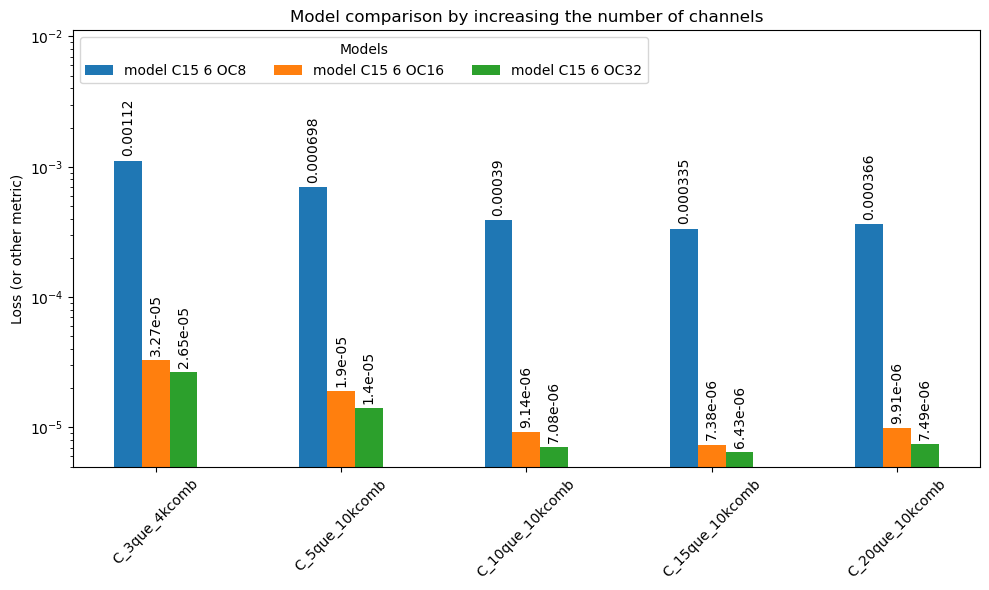

In [75]:
models = [
          model_t6_C15_oc8,
          model_t6_C15_lr,
          model_t6_C15_oc32,
          ]
models_labels = [
                 'model C15 6 OC8',
                 'model C15 6 OC16',
                 'model C15 6 OC32'
                 ]
datasets_files = [# 'dataset/emgALL/og_A_3que_4kcomb_rat5_emgALL.pth',
                 # 'dataset/emgALL/og_A_5que_10kcomb_rat5_emgALL.pth',
                 # 'dataset/emgALL/og_A_10que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_3que_4kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_5que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_10que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_15que_10kcomb_rat5_emgALL.pth',
                 'dataset/emgALL/og_C_20que_10kcomb_rat5_emgALL.pth',
                ]
datasets_labels = [# 'A_3que_4kcomb',
                   # 'A_5que_10kcomb',
                   # 'A_10que_10kcomb',
                   'C_3que_4kcomb',
                   'C_5que_10kcomb',
                   'C_10que_10kcomb',
                   'C_15que_10kcomb',
                   'C_20que_10kcomb',
                   ]

my_models_results = compare_models(models, datasets_files, models_labels, datasets_labels, title='Model comparison by increasing the number of channels')

### d) compare models vs number of queries 

In [82]:
def compare_models_plot(models, models_labels, nb_queries_list, dataset_files, title="Model Comparison", figsize=(10, 8)):
    """

    """
    num_models = len(models_labels)  # Number of models
    num_dataset = len(dataset_files)  # Number of datasets

    # Initialize the figure for plotting
    plt.figure(figsize=figsize)

    models_results = np.zeros((num_models, num_dataset))

    for i in range(num_dataset):
        my_test_loader = get_loader(dataset_files=[dataset_files[i]])
        for j in range(num_models):
            models_results[j,i]= evaluate_model(model=models[j], test_loader=my_test_loader, 
                                                             criterion_function=custom_loss, device=device)
    for j in range(num_models):   
        plt.plot(nb_queries_list, models_results[j], label=models_labels[j])
    plt.yscale('log')
    plt.tight_layout()  # Adjust layout to make sure everything fits well
    plt.legend()
    plt.show()  # Display the chart

    return(models_results)

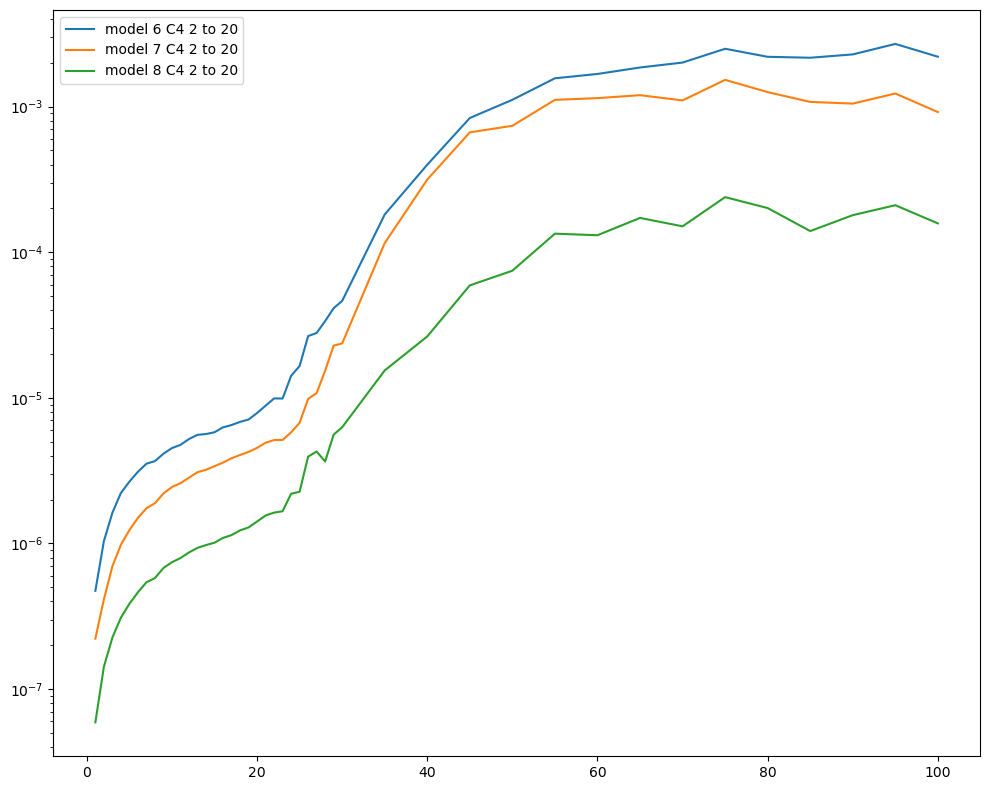

array([[4.72770466e-07, 1.03617464e-06, 1.62475372e-06, 2.22063625e-06,
        2.65739704e-06, 3.10633725e-06, 3.52822624e-06, 3.67687028e-06,
        4.13338003e-06, 4.51814522e-06, 4.75449019e-06, 5.21348929e-06,
        5.57145531e-06, 5.64140569e-06, 5.80434257e-06, 6.27221398e-06,
        6.50611487e-06, 6.83790427e-06, 7.09890978e-06, 7.86650480e-06,
        8.82925306e-06, 9.91186134e-06, 9.89027831e-06, 1.41500625e-05,
        1.65592862e-05, 2.65569627e-05, 2.78967846e-05, 3.37024479e-05,
        4.13039330e-05, 4.63026152e-05, 1.81741532e-04, 3.99456624e-04,
        8.35734248e-04, 1.11518048e-03, 1.56643551e-03, 1.67765451e-03,
        1.85820773e-03, 2.00909708e-03, 2.49847130e-03, 2.20063607e-03,
        2.16829101e-03, 2.28563766e-03, 2.69780453e-03, 2.20371785e-03],
       [2.22113499e-07, 4.12828399e-07, 6.96338162e-07, 9.79212496e-07,
        1.23489583e-06, 1.49946947e-06, 1.74448093e-06, 1.88996861e-06,
        2.20343591e-06, 2.44244766e-06, 2.59289409e-06, 2.82843

In [83]:
models = [
          model_t6_C4_2to20,
          model_t7_C4_2to20,
          model_t8_C4_2to20,
          ]
models_labels = [
                 'model 6 C4 2 to 20',
                 'model 7 C4 2 to 20',
                 'model 8 C4 2 to 20'
                 ]



nb_queries_list = [i for i in range(1,31)] + [i for i in range(35,101,5)]

dataset_files = [f'dataset/test_rat/og_C4_{i}que_rat5_emgALLtest.pth' for i in nb_queries_list]

compare_models_plot(models, models_labels, nb_queries_list, dataset_files)